In [35]:
#前期分析
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO
from docx import Document
from docx.shared import Inches
import os  # 导入 os 用于文件检查

# 1. 读取插补后的数据
data = pd.read_csv('nhanes_data_imputed.csv')

# 2. 指定权重和设计
weights = data['weight.new']

# 3. 定义要分析的变量
binary_dependent_vars = ['T2D', 'hypertension']
continuous_dependent_vars = ['LBXTR', 'LBDHDD', 'LBDLDL', 'LBXTC']
independent_vars = ['DXXTRFAT', 'DXDTRPF', 'DXDTOFAT', 'DXDTOPF']

# 4. 创建记录回归结果的字典
regression_results = {}

# 5. 创建逻辑回归模型的函数
def logistic_regression(dependent_var):
    print(f"Analyzing relationship with {dependent_var} (Logistic Regression):")
    
    # 提取自变量和因变量
    X = data[independent_vars]
    y = data[dependent_var]
    
    # 加入常数项
    X = sm.add_constant(X)

    # 使用逻辑回归
    model = sm.Logit(y, X)
    results = model.fit()  # 在拟合时传递权重
    
    # 打印回归结果
    print(results.summary())
    
    # 将结果保存到字典
    regression_results[dependent_var] = results.summary().tables[1].as_html(escape=False)
    return  # 确保逻辑回归保存结果

# 6. 创建线性回归模型的函数
def linear_regression(dependent_var):
    print(f"Analyzing relationship with {dependent_var} (Linear Regression):")
    
    # 提取自变量和因变量
    X = data[independent_vars]
    y = data[dependent_var]
    
    # 加入常数项
    X = sm.add_constant(X)

    # 使用线性回归
    model = sm.OLS(y, X)
    results = model.fit(weights=weights)  # 在拟合时传递权重
    
    # 打印回归结果
    print(results.summary())
    
    # 将结果保存到字典
    regression_results[dependent_var] = results.summary().tables[1].as_html(escape=False)

    # 创建子图
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()  # 将 2D 数组扁平化为 1D 方便迭代

    for i, var in enumerate(independent_vars):
        sns.regplot(x=X[var], y=y, ax=axes[i], scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
        axes[i].set_title(f'{dependent_var} vs {var}')
        axes[i].set_xlabel(var)
        axes[i].set_ylabel(dependent_var)

    plt.tight_layout()  # 调整子图间距
    
    # 保存图像
    plot_filename = f'{dependent_var}_combined_regression_plot.png'
    plt.savefig(plot_filename)
    plt.close()  # 清理图像以免干扰后续图形
    
    return plot_filename

# 7. 分别分析二分类和连续因变量
plot_filenames = {}

# 处理二分类变量
for var in binary_dependent_vars:
    logistic_regression(var)

# 处理连续变量
for var in continuous_dependent_vars:
    plot_filenames[var] = linear_regression(var)

# 8. 创建 Word 文档
doc = Document()
doc.add_heading('Regression Analysis Results', level=1)

# 添加二分类变量的结果
for dep_var in binary_dependent_vars:
    doc.add_heading(f'Analysis for {dep_var}', level=2)
    
    # 添加回归结果表格
    doc.add_paragraph(f'Regression results for {dep_var}:')
    df_results = pd.read_html(StringIO(regression_results[dep_var]))[0]  # 使用 StringIO
    
    df_results.columns = df_results.columns.astype(str)  # 确保列名是字符串

    # 创建表格
    table = doc.add_table(rows=1, cols=len(df_results.columns))
    
    # 设置列名
    for col_idx, col_name in enumerate(df_results.columns):
        table.cell(0, col_idx).text = str(col_name)

    # 填充表格数据
    for row in df_results.itertuples(index=False):
        cells = table.add_row().cells
        for col_idx, value in enumerate(row):
            cells[col_idx].text = str(value)

    # 插入组合图
    plot_filename = f'{dep_var}_combined_regression_plot.png'
    
    # 检查文件是否存在
    if os.path.exists(plot_filename):
        doc.add_picture(plot_filename, width=Inches(5.0))
        doc.add_paragraph(f'Figure: {dep_var} Combined Regression Plots')
    else:
        print(f"Warning: {plot_filename} not found.")

# 添加连续变量的结果
for dep_var in continuous_dependent_vars:
    doc.add_heading(f'Analysis for {dep_var}', level=2)
    
    # 添加回归结果表格
    doc.add_paragraph(f'Regression results for {dep_var}:')
    df_results = pd.read_html(StringIO(regression_results[dep_var]))[0]  # 使用 StringIO
    
    df_results.columns = df_results.columns.astype(str)  # 确保列名是字符串

    # 创建表格
    table = doc.add_table(rows=1, cols=len(df_results.columns))
    
    # 设置列名
    for col_idx, col_name in enumerate(df_results.columns):
        table.cell(0, col_idx).text = str(col_name)

    # 填充表格数据
    for row in df_results.itertuples(index=False):
        cells = table.add_row().cells
        for col_idx, value in enumerate(row):
            cells[col_idx].text = str(value)

    # 插入组合图
    plot_filename = f'{dep_var}_combined_regression_plot.png'
    
    # 检查文件是否存在
    if os.path.exists(plot_filename):
        doc.add_picture(plot_filename, width=Inches(5.0))
        doc.add_paragraph(f'Figure: {dep_var} Combined Regression Plots')
    else:
        print(f"Warning: {plot_filename} not found.")

# 9. 保存文档
doc_filename = 'Regression_Analysis_Results.docx'
doc.save(doc_filename)
print(f"文档已保存为: {doc_filename}")

Analyzing relationship with T2D (Logistic Regression):
Optimization terminated successfully.
         Current function value: 0.307518
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    T2D   No. Observations:                30443
Model:                          Logit   Df Residuals:                    30438
Method:                           MLE   Df Model:                            4
Date:                Wed, 11 Jun 2025   Pseudo R-squ.:                  0.1163
Time:                        09:21:36   Log-Likelihood:                -9361.8
converged:                       True   LL-Null:                       -10593.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.5161      0.091    -38.826      0.00

训练集和测试集已保存为 train_data.csv 和 test_data.csv
训练集和测试集的特征已更新和独热编码完成。

特征重要性分析
连续变量: ['Age', 'Weight', 'Waist', 'Height']
分类变量: ['Mexican American', 'Other Hispanic', 'Non-Hispanic Black', 'Other Race', 'Female']


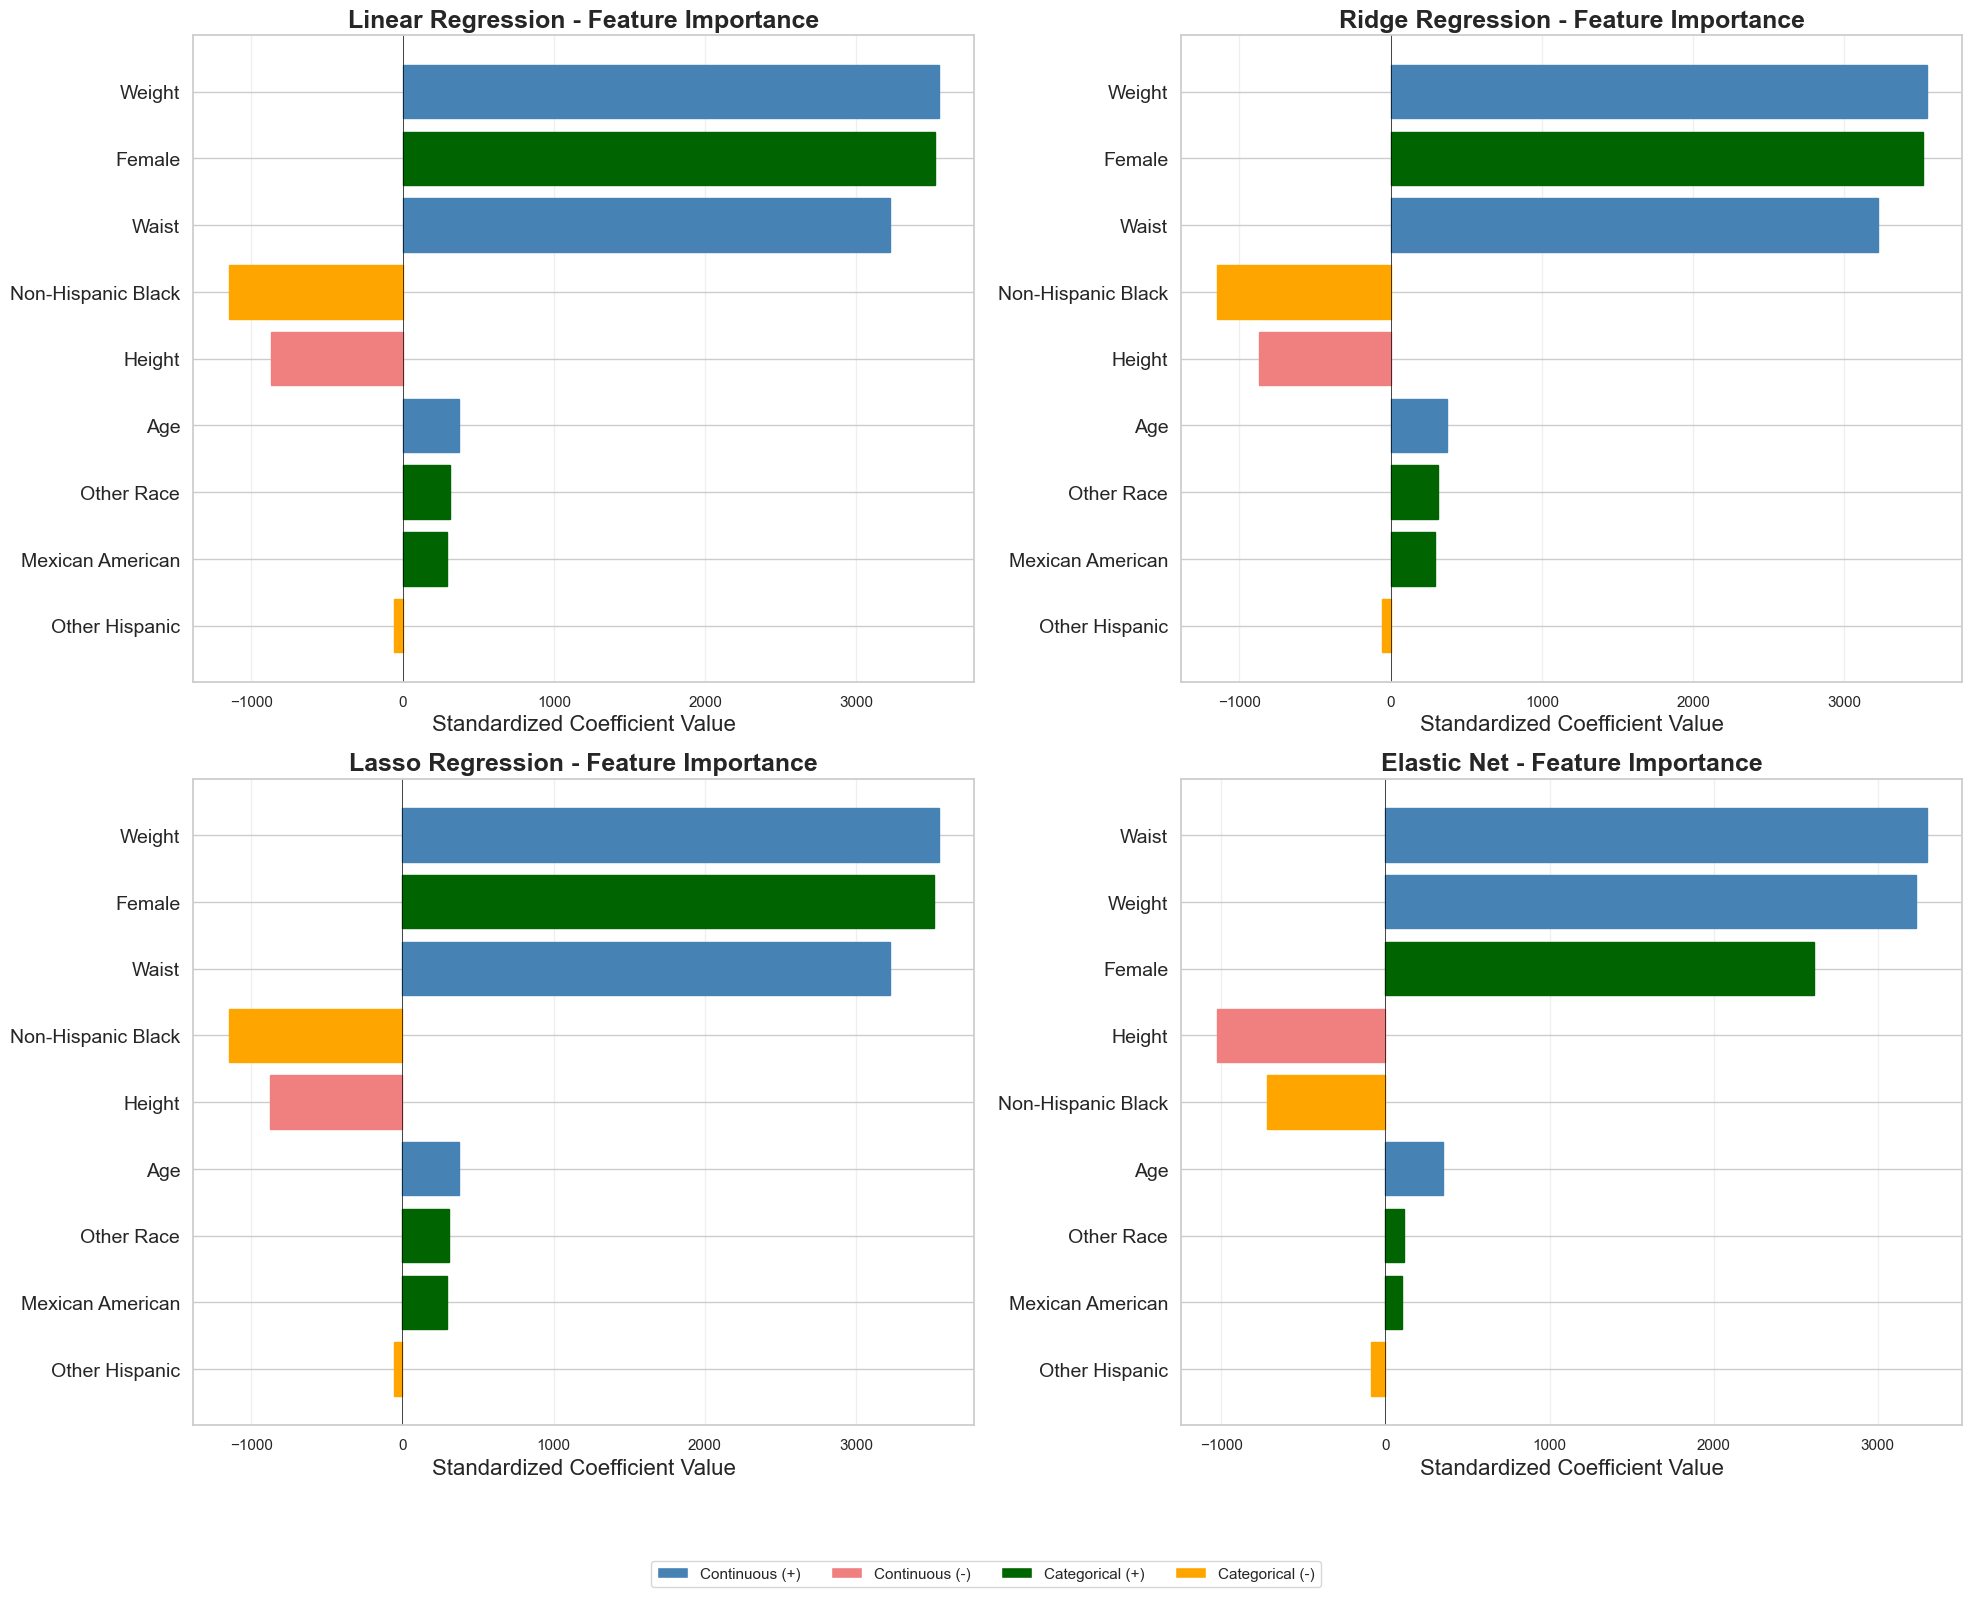

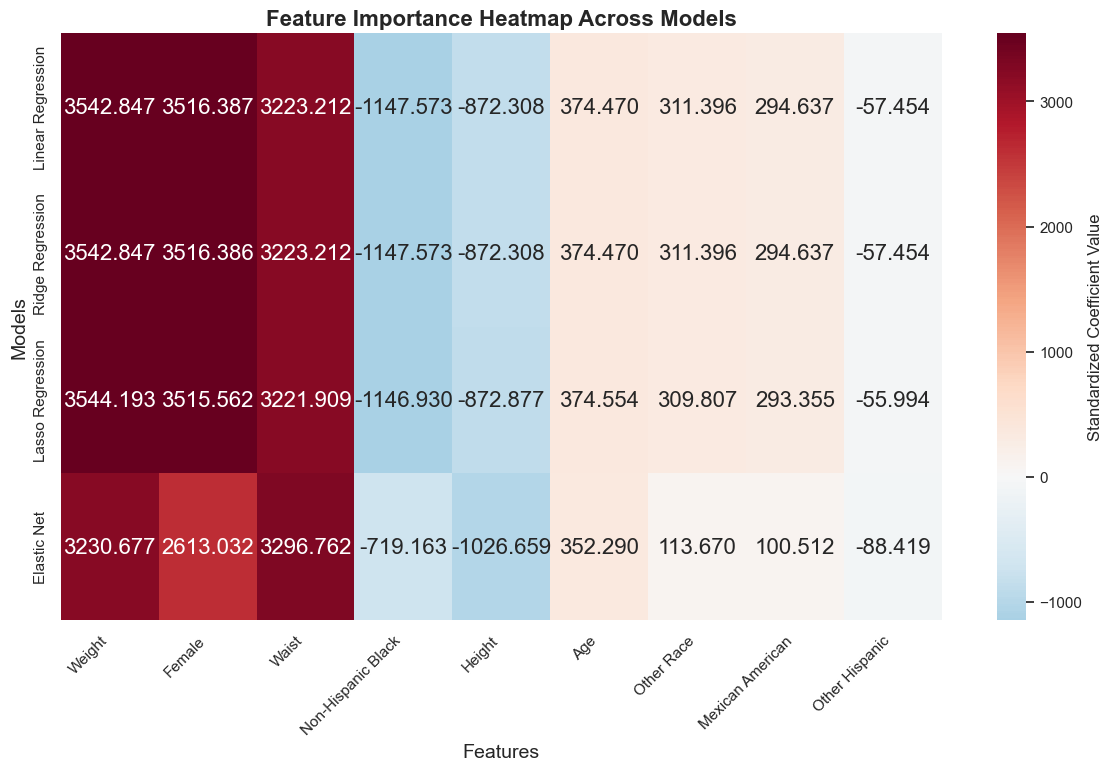


特征重要性汇总表（基于标准化系数）：
                    Linear Regression  Ridge Regression  Lasso Regression  \
Weight                      3542.8472         3542.8471         3544.1928   
Female                      3516.3866         3516.3864         3515.5625   
Waist                       3223.2116         3223.2116         3221.9087   
Non-Hispanic Black         -1147.5731        -1147.5730        -1146.9302   
Height                      -872.3076         -872.3077         -872.8769   
Age                          374.4703          374.4702          374.5540   
Other Race                   311.3959          311.3958          309.8066   
Mexican American             294.6373          294.6372          293.3551   
Other Hispanic               -57.4540          -57.4541          -55.9940   

                    Elastic Net  Average_Abs_Importance  
Weight                3230.6771               3465.1410  
Female                2613.0317               3290.3418  
Waist                 3296.7619    

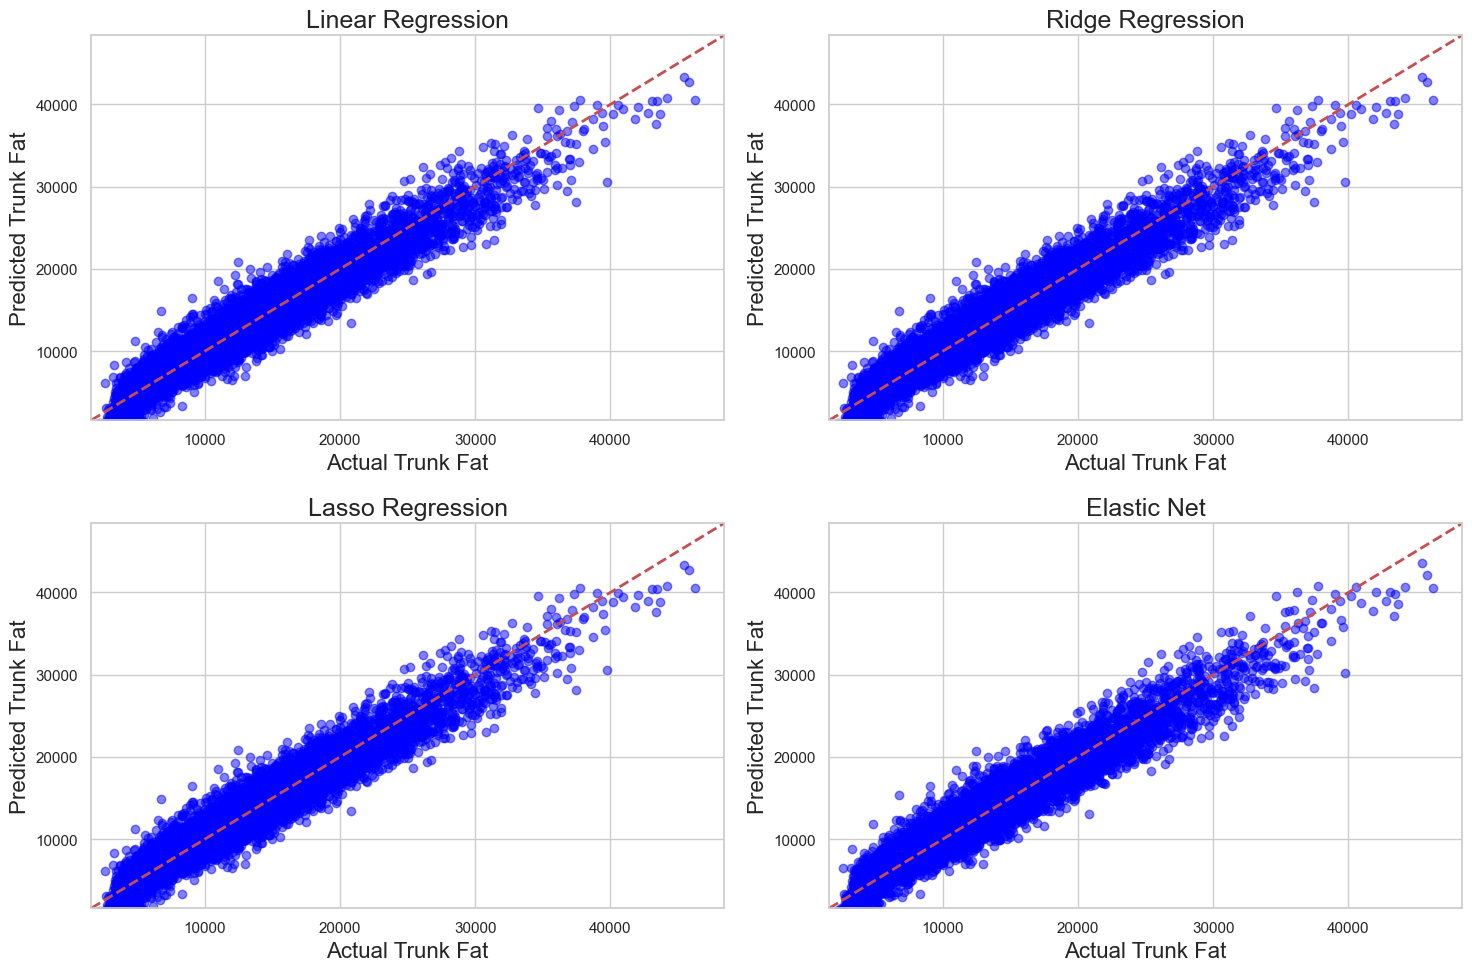

               Model  Mean Squared Error  R^2 Score  Mean Absolute Error  \
0  Linear Regression        3.158402e+06   0.926497          1379.843224   
1   Ridge Regression        3.158402e+06   0.926497          1379.843220   
2   Lasso Regression        3.158372e+06   0.926497          1379.828220   
3        Elastic Net        3.281704e+06   0.923627          1401.009048   

   Explained Variance Score    Max Error  
0                  0.926534  9241.346459  
1                  0.926534  9241.346409  
2                  0.926534  9241.171476  
3                  0.923637  9548.227005  

实用预测公式（基于原始数据，可直接使用）

Linear Regression Prediction Formula:
Predicted Trunk Fat = -7539.5366 + 21.5382 * Age + 171.2266 * Weight + 198.5444 * Waist - 86.6588 * Height + 294.6373 * Mexican American - 57.4540 * Other Hispanic - 1147.5731 * Non-Hispanic Black + 311.3959 * Other Race + 3516.3866 * Female 

Ridge Regression Prediction Formula:
Predicted Trunk Fat = -7539.5348 + 21.5382 * Age + 171.2266 * 

In [5]:
# 分割数据，分隔后数据进行表一生成
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from docx import Document
from docx.shared import Inches
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor  # 添加Random Forest
from sklearn.metrics import (
    mean_squared_error, 
    r2_score, 
    mean_absolute_error, 
    explained_variance_score, 
    max_error
)

# 设置Seaborn和Matplotlib的风格
sns.set(style="whitegrid")
plt.rcParams['font.size'] = 16  # 设置字体大小

# 1. 读取数据集
data = pd.read_csv('nhanes_data_imputed.csv')  # 请根据您的数据文件适当调整

# 2. 定义自变量和因变量
X = data[['T2D', 'hypertension', 'RIDRETH1', 'RIAGENDR', 'RIDAGEYR', 'BMXBMI', 'BMXWAIST', 'BODYWEIGHT', 'LBXTR', 'LBDHDD', 'LBDLDL', 'LBXTC', 'SDMVPSU', 'SDMVSTRA', 'BMXHT']]
y_trunk_fat = data['DXXTRFAT']
y_fat_ratio = data['DXDTRPF']
weights = data['weight.new']

# 3. 切分数据集为训练集和测试集
X_train, X_test, y_train_fat, y_test_fat, y_train_ratio, y_test_ratio = train_test_split(
    X, y_trunk_fat, y_fat_ratio, test_size=0.3, random_state=42
)

# 4. 创建训练集和测试集的数据框
train_data = X_train.copy()
train_data['DXXTRFAT'] = y_train_fat
train_data['DXDTRPF'] = y_train_ratio
train_data['weight.new'] = weights.loc[X_train.index]  # 使用权重

test_data = X_test.copy()
test_data['DXXTRFAT'] = y_test_fat
test_data['DXDTRPF'] = y_test_ratio
test_data['weight.new'] = weights.loc[X_test.index]  # 使用权重

# 5. 保存训练集和测试集到 CSV 文件
train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

print("训练集和测试集已保存为 train_data.csv 和 test_data.csv")


# 2. 提取需要的特征
# 假设之前您已经取得了 X_train 和 X_test
X_train = X_train[['RIDAGEYR', 'BODYWEIGHT', 'BMXWAIST', 'BMXHT', 'RIDRETH1', 'RIAGENDR']]
X_test = X_test[['RIDAGEYR', 'BODYWEIGHT', 'BMXWAIST', 'BMXHT', 'RIDRETH1', 'RIAGENDR']]

# 3. 对分类变量进行独热编码，手动指定要删除的基准类别
X_train_encoded = pd.get_dummies(X_train, columns=['RIDRETH1', 'RIAGENDR'], drop_first=False)
X_test_encoded = pd.get_dummies(X_test, columns=['RIDRETH1', 'RIAGENDR'], drop_first=False)

# 删除RIDRETH1_3和RIAGENDR_1作为基准类别
columns_to_drop = []
if 'RIDRETH1_3' in X_train_encoded.columns:
    columns_to_drop.append('RIDRETH1_3')
if 'RIAGENDR_1' in X_train_encoded.columns:
    columns_to_drop.append('RIAGENDR_1')

X_train_encoded = X_train_encoded.drop(columns=columns_to_drop)
X_test_encoded = X_test_encoded.drop(columns=columns_to_drop)

# 重命名变量为更直观的名称
rename_dict = {
    'RIDAGEYR': 'Age',
    'BODYWEIGHT': 'Weight',
    'BMXHT': 'Height',
    'BMXWAIST': 'Waist',
    'RIAGENDR_2': 'Female',
    'RIDRETH1_1': 'Mexican American',
    'RIDRETH1_2': 'Other Hispanic',
    'RIDRETH1_4': 'Non-Hispanic Black',
    'RIDRETH1_5': 'Other Race'
}

X_train_encoded = X_train_encoded.rename(columns=rename_dict)
X_test_encoded = X_test_encoded.rename(columns=rename_dict)


# 4. 确保训练和测试集中具有相同的列（处理缺失列）
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

# 更新 X_train 和 X_test 为编码后的版本
X_train = X_train_encoded
X_test = X_test_encoded

print("训练集和测试集的特征已更新和独热编码完成。")

# 1. 多元线性回归
linear_model = LinearRegression()
linear_model.fit(X_train, y_train_fat, sample_weight=weights.loc[X_train.index])  # 加入权重
y_pred_fat_linear = linear_model.predict(X_test)

# 2. 岭回归
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train_fat, sample_weight=weights.loc[X_train.index])  # 加入权重
y_pred_fat_ridge = ridge_model.predict(X_test)

# 3. 套索回归
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train_fat, sample_weight=weights.loc[X_train.index])  # 加入权重
y_pred_fat_lasso = lasso_model.predict(X_test)

# 4. 弹性网回归
elastic_net_model = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net_model.fit(X_train, y_train_fat, sample_weight=weights.loc[X_train.index])  # 加入权重
y_pred_fat_elastic = elastic_net_model.predict(X_test)

# =================== 插入特征重要性分析 ===================
print("\n" + "="*80)
print("特征重要性分析")
print("="*80)

# 保存原始模型（用于生成预测公式）
original_models = {
    'Linear Regression': linear_model,
    'Ridge Regression': ridge_model,
    'Lasso Regression': lasso_model,
    'Elastic Net': elastic_net_model
}

# 为特征重要性分析创建标准化数据
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# 分离连续变量和分类变量
continuous_vars = ['Age', 'Weight', 'Waist', 'Height']
categorical_vars = [col for col in X_train.columns if col not in continuous_vars]

print(f"连续变量: {continuous_vars}")
print(f"分类变量: {categorical_vars}")

# 标准化连续变量
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[continuous_vars] = scaler.fit_transform(X_train[continuous_vars])
X_test_scaled[continuous_vars] = scaler.transform(X_test[continuous_vars])

# 使用标准化数据训练模型（仅用于特征重要性分析）
scaled_models = {}

linear_scaled = LinearRegression()
linear_scaled.fit(X_train_scaled, y_train_fat, sample_weight=weights.loc[X_train.index])
scaled_models['Linear Regression'] = linear_scaled

ridge_scaled = Ridge(alpha=1.0)
ridge_scaled.fit(X_train_scaled, y_train_fat, sample_weight=weights.loc[X_train.index])
scaled_models['Ridge Regression'] = ridge_scaled

lasso_scaled = Lasso(alpha=0.1)
lasso_scaled.fit(X_train_scaled, y_train_fat, sample_weight=weights.loc[X_train.index])
scaled_models['Lasso Regression'] = lasso_scaled

elastic_scaled = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_scaled.fit(X_train_scaled, y_train_fat, sample_weight=weights.loc[X_train.index])
scaled_models['Elastic Net'] = elastic_scaled

# 创建特征重要性图
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.ravel()

feature_names = X_train_scaled.columns.tolist()

for idx, (model_name, model) in enumerate(scaled_models.items()):
    coefficients = model.coef_
    
    # 创建特征重要性DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Abs_Coefficient': np.abs(coefficients),
        'Variable_Type': ['Continuous' if name in continuous_vars else 'Categorical' 
                         for name in feature_names]
    }).sort_values('Abs_Coefficient', ascending=True)
    
    # 绘制水平条形图
    bars = axes[idx].barh(range(len(importance_df)), importance_df['Coefficient'])
    
    # 为不同类型的变量和正负系数设置颜色
    for i, (bar, coef, var_type) in enumerate(zip(bars, importance_df['Coefficient'], importance_df['Variable_Type'])):
        if var_type == 'Continuous':
            if coef >= 0:
                bar.set_color('steelblue')
            else:
                bar.set_color('lightcoral')
        else:  # Categorical
            if coef >= 0:
                bar.set_color('darkgreen')
            else:
                bar.set_color('orange')
    
    axes[idx].set_yticks(range(len(importance_df)))
    axes[idx].set_yticklabels(importance_df['Feature'], fontsize=14)
    axes[idx].set_xlabel('Standardized Coefficient Value', fontsize=16)
    axes[idx].set_title(f'{model_name} - Feature Importance', fontsize=18, fontweight='bold')
    axes[idx].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    axes[idx].grid(axis='x', alpha=0.3)

# 添加图例
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='steelblue', label='Continuous (+)'),
                   Patch(facecolor='lightcoral', label='Continuous (-)'),
                   Patch(facecolor='darkgreen', label='Categorical (+)'),
                   Patch(facecolor='orange', label='Categorical (-)')]
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.02), ncol=4)

plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
plt.savefig('standardized_feature_importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 创建特征重要性热力图
importance_summary = pd.DataFrame(index=feature_names)
for model_name, model in scaled_models.items():
    importance_summary[model_name] = model.coef_

importance_summary['Average_Abs_Importance'] = importance_summary.abs().mean(axis=1)
importance_summary = importance_summary.sort_values('Average_Abs_Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.heatmap(importance_summary.iloc[:, :-1].T, 
            annot=True, 
            cmap='RdBu_r', 
            center=0,
            fmt='.3f',
            cbar_kws={'label': 'Standardized Coefficient Value'})
plt.title('Feature Importance Heatmap Across Models', fontsize=16, fontweight='bold')
plt.xlabel('Features', fontsize=14)
plt.ylabel('Models', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('feature_importance_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# 打印特征重要性汇总
print(f"\n特征重要性汇总表（基于标准化系数）：")
print(importance_summary.round(4))

print(f"\n前5个最重要的特征：")
for i, (feature, row) in enumerate(importance_summary.head(5).iterrows(), 1):
    var_type = "连续变量" if feature in continuous_vars else "分类变量"
    print(f"{i}. {feature} ({var_type}): 平均绝对重要性 = {row['Average_Abs_Importance']:.4f}")

# 分析套索回归的特征选择结果
lasso_selected_features = [name for name, coef in zip(feature_names, lasso_scaled.coef_) if abs(coef) > 1e-6]
print(f"\n套索回归选择的特征数量: {len(lasso_selected_features)}/{len(feature_names)}")
if len(lasso_selected_features) < len(feature_names):
    excluded_features = [name for name in feature_names if name not in lasso_selected_features]
    print(f"被排除的特征: {excluded_features}")

print(f"\n注意：以上特征重要性分析基于标准化数据，主要用于比较不同变量的相对重要性")
print("="*80)

# =================== 继续原有的预测结果分析 ===================

# 将结果整理到字典中
results = {
    'Linear Regression': y_pred_fat_linear,
    'Ridge Regression': y_pred_fat_ridge,
    'Lasso Regression': y_pred_fat_lasso,
    'Elastic Net': y_pred_fat_elastic
}

# 创建一个图形以显示每种模型的预测结果
plt.figure(figsize=(15, 10))

for i, (model_name, y_pred) in enumerate(results.items(), 1):
    plt.subplot(2, 2, i)  # 创建 2x2 的子图
    plt.scatter(y_test_fat, y_pred, color='blue', alpha=0.5)
    plt.plot([y_test_fat.min(), y_test_fat.max()], 
             [y_test_fat.min(), y_test_fat.max()], 'r--', lw=2)  # 45度线
    plt.title(f'{model_name}', fontsize=18)
    plt.xlabel('Actual Trunk Fat', fontsize=16)
    plt.ylabel('Predicted Trunk Fat', fontsize=16)
    plt.xlim([y_test_fat.min(), y_test_fat.max()])
    plt.ylim([y_test_fat.min(), y_test_fat.max()])

plt.tight_layout()
plt.savefig('trunk_fat_predictions_comparison.png', dpi=300)  # 保存图片
plt.show()

# 创建一个空的 DataFrame 来保存性能指标
performance_metrics = []

# 计算并打印每个模型的性能指标
for model_name, y_pred in results.items():
    mse = mean_squared_error(y_test_fat, y_pred)
    r2 = r2_score(y_test_fat, y_pred)
    mae = mean_absolute_error(y_test_fat, y_pred)
    evs = explained_variance_score(y_test_fat, y_pred)
    max_err = max_error(y_test_fat, y_pred)
    
    performance_metrics.append({
        'Model': model_name,
        'Mean Squared Error': mse,
        'R^2 Score': r2,
        'Mean Absolute Error': mae,
        'Explained Variance Score': evs,
        'Max Error': max_err
    })

# 转换为 DataFrame
metrics_df = pd.DataFrame(performance_metrics)

# 打印性能指标
print(metrics_df)

# 创建 Word 文档并添加表格
doc = Document()
doc.add_heading('Model Performance Metrics', level=1)

# 添加表格
table = doc.add_table(rows=1, cols=len(metrics_df.columns))
table.style = 'Table Grid'

# 添加列标题
hdr_cells = table.rows[0].cells
for i, column_name in enumerate(metrics_df.columns):
    hdr_cells[i].text = column_name

# 添加数据行
for index, row in metrics_df.iterrows():
    row_cells = table.add_row().cells
    for i, value in enumerate(row):
        row_cells[i].text = str(value)

# 保存文档
doc.save('model_performance_metrics.docx')

# 创建一个函数来生成预测公式（基于原始数据模型）
def generate_prediction_formula(model, feature_names):
    # 提取截距和系数
    intercept = model.intercept_
    coefficients = model.coef_

    # 构建预测公式
    formula = f'Predicted Trunk Fat = {intercept:.4f} '
    for coef, name in zip(coefficients, feature_names):
        if coef >= 0:
            formula += f'+ {coef:.4f} * {name} '
        else:
            formula += f'- {abs(coef):.4f} * {name} '

    return formula

# 获取编码后的训练集特征名称
feature_names = X_train.columns.tolist()  # 确保从正确的数据中提取列名

# 生成每个模型的预测公式（使用原始数据模型）
print(f"\n" + "="*80)
print("实用预测公式（基于原始数据，可直接使用）")
print("="*80)

formulas = {}
for model_name, model in original_models.items():
    formula = generate_prediction_formula(model, feature_names)
    formulas[model_name] = formula
    print(f'\n{model_name} Prediction Formula:')
    print(f'{formula}')

# 创建 Word 文档并保存预测公式
doc = Document()
doc.add_heading('Prediction Formulas', level=1)

# 添加说明
doc.add_paragraph('注意：以下公式基于原始数据训练，可直接输入实际测量值进行预测。')
doc.add_paragraph('连续变量系数表示该变量增加1个单位时目标变量的预期变化。')
doc.add_paragraph('分类变量系数表示相对于基准组的差异。')

# 添加每个模型的预测公式
for model_name, formula in formulas.items():
    doc.add_heading(model_name, level=2)
    doc.add_paragraph(formula)

# 保存 Word 文档
doc.save('prediction_formulas.docx')

print(f"\n所有分析完成！生成的文件包括：")
print(f"- standardized_feature_importance_comparison.png: 特征重要性对比图")
print(f"- feature_importance_heatmap.png: 特征重要性热力图")
print(f"- trunk_fat_predictions_comparison.png: 预测结果对比图")
print(f"- model_performance_metrics.docx: 模型性能指标表")
print(f"- prediction_formulas.docx: 实用预测公式")

🔍 线性回归模型 - 特征简化优化分析

📊 当前线性回归特征重要性分析:

🏆 特征重要性排序（基于系数绝对值）:
 1. 🏷️ Female              : 3516.3866 (分类变量)
 2. 🏷️ Non-Hispanic Black  : 1147.5731 (分类变量)
 3. 🏷️ Other Race          : 311.3959 (分类变量)
 4. 🏷️ Mexican American    : 294.6373 (分类变量)
 5. 📏 Waist               : 198.5444 (连续变量)
 6. 📏 Weight              : 171.2266 (连续变量)
 7. 📏 Height              : 86.6588 (连续变量)
 8. 🏷️ Other Hispanic      : 57.4540 (分类变量)
 9. 📏 Age                 : 21.5382 (连续变量)

📋 特征简化策略设计:
✅ 策略1 - Top 5特征: ['Female', 'Non-Hispanic Black', 'Other Race', 'Mexican American', 'Waist']
✅ 策略2 - Top 3特征: ['Female', 'Non-Hispanic Black', 'Other Race']
✅ 策略3 - 阈值筛选(>500): ['Female', 'Non-Hispanic Black']
✅ 策略4 - 仅连续变量: ['Waist', 'Weight', 'Height', 'Age']
✅ 策略5 - 混合特征: ['Waist', 'Weight', 'Height', 'Age', 'Female']
✅ 策略6 - 生物学核心: ['Weight', 'Female', 'Waist', 'Height']

🚀 训练简化线性回归模型对比:
--------------------------------------------------------------------------------

🔧 训练 Original (All Features) (9个特征)...
   📈 R² = 0.

D:\ana\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
D:\ana\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
D:\ana\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


   📈 R² = 0.9025, MAE = 1565.8104, CV_R² = 0.8983(±0.0036)

🔧 训练 Top 3 Features (3个特征)...
   📈 R² = 0.0371, MAE = 5006.8751, CV_R² = 0.0305(±0.0017)

🔧 训练 Threshold >500 (2个特征)...
   📈 R² = 0.0242, MAE = 5058.9165, CV_R² = 0.0201(±0.0017)

🔧 训练 Continuous Only (4个特征)...


D:\ana\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
D:\ana\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
D:\ana\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


   📈 R² = 0.8869, MAE = 1726.7512, CV_R² = 0.8857(±0.0047)

🔧 训练 Mixed Features (5个特征)...
   📈 R² = 0.9212, MAE = 1429.6341, CV_R² = 0.9195(±0.0036)

🔧 训练 Biological Core (4个特征)...
   📈 R² = 0.9198, MAE = 1444.5226, CV_R² = 0.9181(±0.0034)

📊 简化策略性能对比
                  Strategy  Features      R²        MAE  CV_R²_Mean
0  Original (All Features)         9  0.9265  1379.8432      0.9259
5           Mixed Features         5  0.9212  1429.6341      0.9195
6          Biological Core         4  0.9198  1444.5226      0.9181
1           Top 5 Features         5  0.9025  1565.8104      0.8983
4          Continuous Only         4  0.8869  1726.7512      0.8857
2           Top 3 Features         3  0.0371  5006.8751      0.0305
3           Threshold >500         2  0.0242  5058.9165      0.0201


D:\ana\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


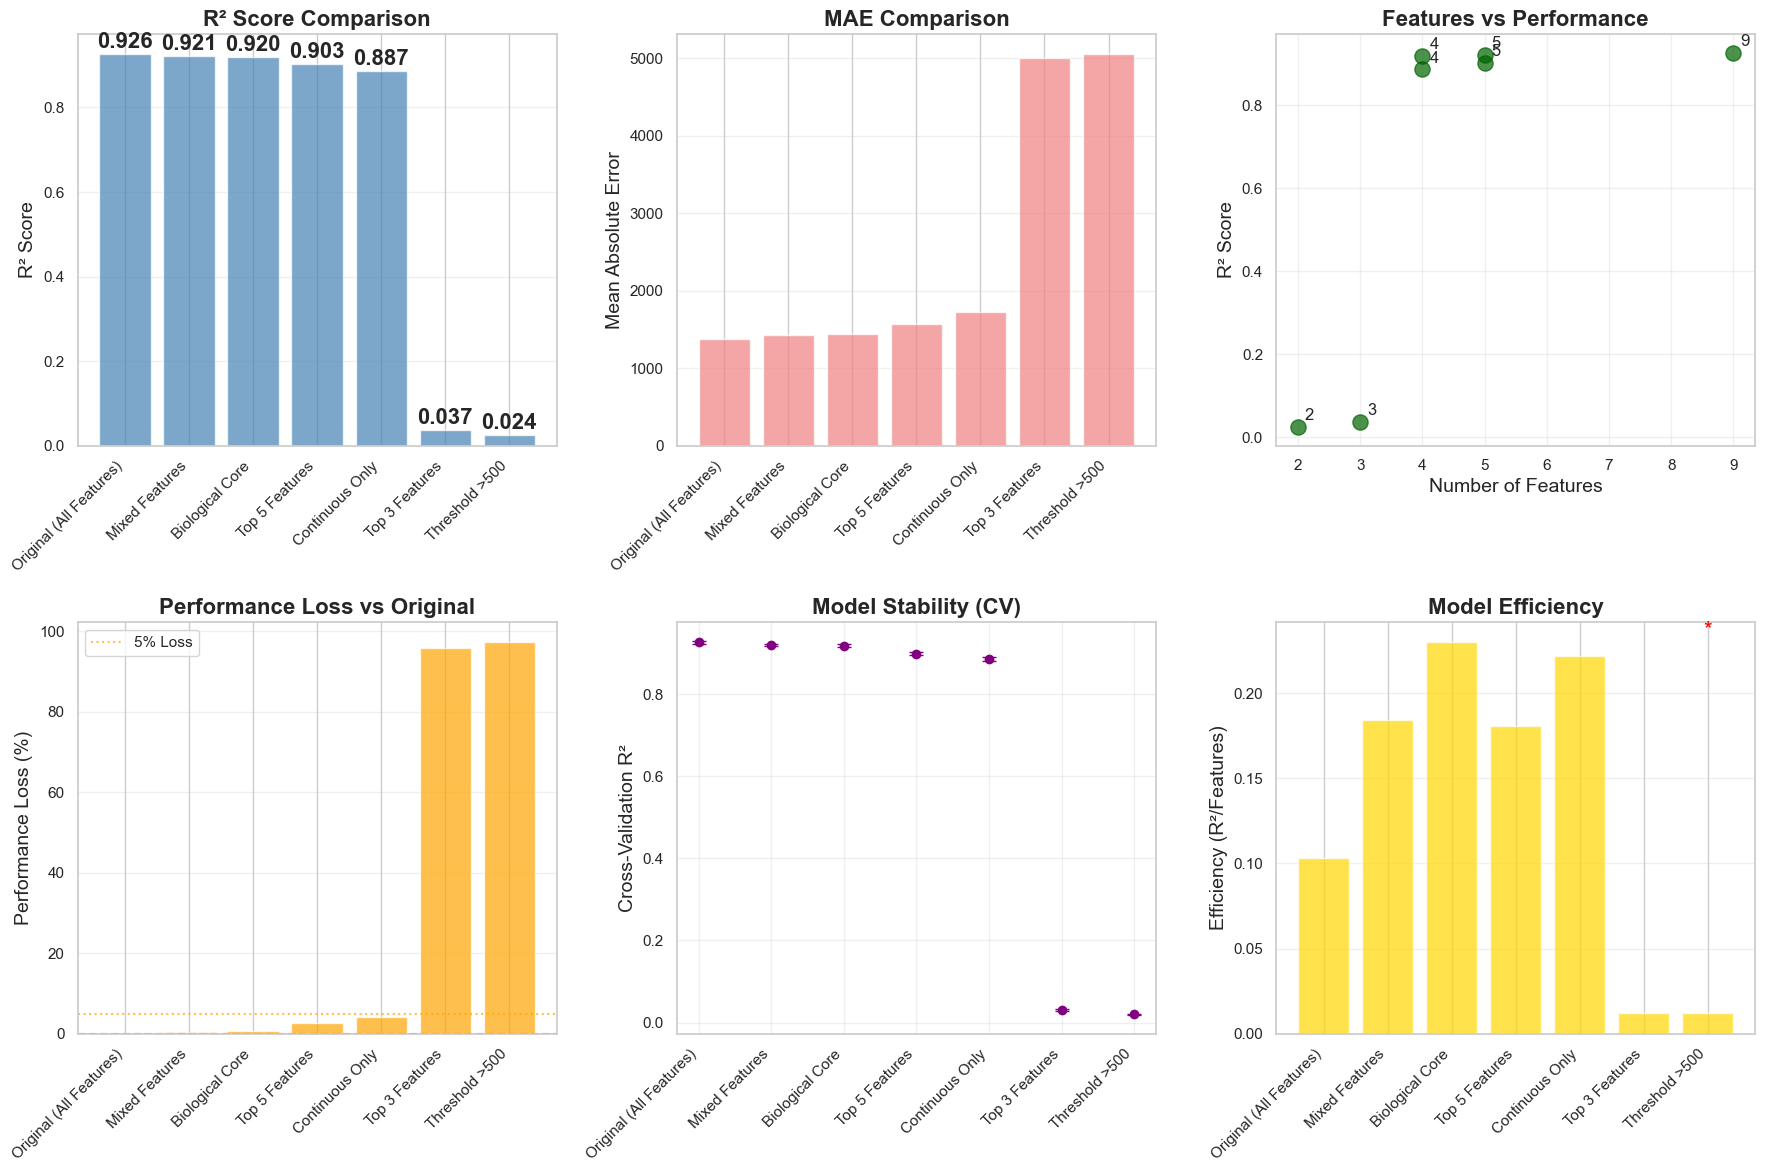


🎯 推荐简化策略分析
🏆 推荐策略: Biological Core
📊 特征数量: 4 (原始: 9)
📈 R²得分: 0.9198 (原始: 0.9265)
📉 性能损失: 0.72%
🎯 MAE: 1444.5226
🔄 CV稳定性: 0.9181(±0.0034)
⚡ 综合评分: 72.82/100

✅ 选定特征列表:
  1. 📏 Weight (系数: 171.2266, 连续变量)
  2. 🏷️ Female (系数: 3516.3866, 分类变量)
  3. 📏 Waist (系数: 198.5444, 连续变量)
  4. 📏 Height (系数: -86.6588, 连续变量)

🔧 训练最终简化线性回归模型...

🎉 最终简化模型性能:
   R² = 0.9198
   MAE = 1444.5226
   MSE = 3446205.2071
   EVS = 0.9198

📝 最终预测公式:
躯干脂肪(g) = -8630.8062 + 144.8131 × Weight + 3450.4311 × Female + 231.9248 × Waist - 81.4678 × Height

📚 系数解释:
• 体重每增加1kg，躯干脂肪增加144.81g
• 女性相比男性，躯干脂肪多3450.43g
• 腰围每增加1cm，躯干脂肪增加231.92g
• 身高每增加1cm，躯干脂肪减少81.47g


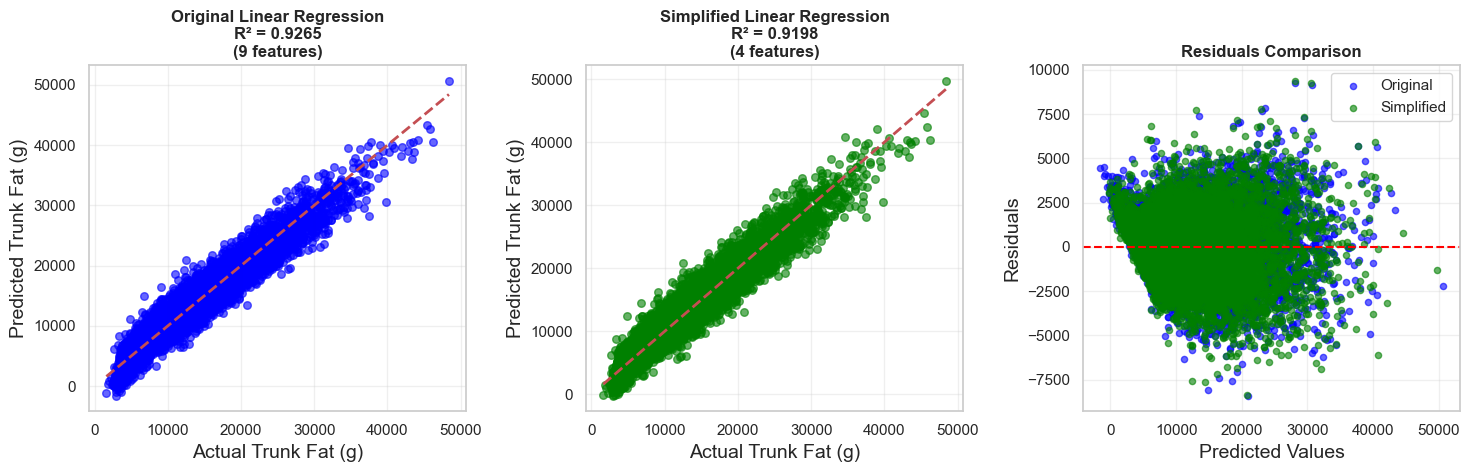


💾 保存简化模型和相关文件...
✅ 文件保存成功:
   • simplified_linear_regression_model.pkl - 简化模型
   • selected_features_linear.pkl - 特征列表
   • simplified_linear_prediction_function.py - 预测函数

🎉 线性回归特征简化总结
🎯 简化效果:
   特征数量: 9 → 4 (减少55.6%)
   性能保持: 99.3% (R²: 0.9265 → 0.9198)
   MAE变化: 1444.5226 → 1444.5226

💡 简化优势:
   ✅ 减少数据收集成本和时间
   ✅ 提高模型可解释性和实用性
   ✅ 降低多重共线性风险
   ✅ 便于临床应用和推广
   ✅ 减少过拟合风险

🚀 应用建议:
   🌟 简化效果优秀！建议优先使用简化模型

📊 最终简化模型特征:
   1. Weight (系数: 144.8131, 连续变量)
   2. Female (系数: 3450.4311, 分类变量)
   3. Waist (系数: 231.9248, 连续变量)
   4. Height (系数: -81.4678, 连续变量)

📈 模型解释:
   • 该模型可解释92.0%的躯干脂肪变异
   • 平均预测误差约±1444.5g
   • 模型简单易懂，适合临床应用

📁 生成文件:
   • linear_regression_feature_simplification_analysis.png - 简化分析
   • linear_regression_before_after_simplification.png - 效果对比
   • simplified_linear_regression_model.pkl - 简化模型
   • selected_features_linear.pkl - 特征列表
   • simplified_linear_prediction_function.py - 预测函数
🎊 线性回归特征简化分析完成！


In [7]:
# =================== 线性回归模型 - 特征简化分析 ===================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from sklearn.model_selection import cross_val_score
import joblib

print("="*80)
print("🔍 线性回归模型 - 特征简化优化分析")
print("="*80)

# =================== 1. 分析当前线性回归的特征重要性 ===================
print("\n📊 当前线性回归特征重要性分析:")

# 获取特征重要性（基于标准化系数的绝对值）
feature_importance_linear = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': linear_model.coef_,
    'Abs_Coefficient': np.abs(linear_model.coef_),
    'Variable_Type': ['连续变量' if name in continuous_vars else '分类变量' 
                     for name in X_train.columns]
}).sort_values('Abs_Coefficient', ascending=False)

print("\n🏆 特征重要性排序（基于系数绝对值）:")
for i, (_, row) in enumerate(feature_importance_linear.iterrows(), 1):
    var_type_icon = "📏" if row['Variable_Type'] == '连续变量' else "🏷️"
    print(f"{i:2d}. {var_type_icon} {row['Feature']:20s}: {row['Abs_Coefficient']:.4f} ({row['Variable_Type']})")

# =================== 2. 定义不同的特征简化策略 ===================
print(f"\n📋 特征简化策略设计:")

# 策略1: 前5个最重要特征
top5_features = feature_importance_linear.head(5)['Feature'].tolist()
print(f"✅ 策略1 - Top 5特征: {top5_features}")

# 策略2: 前3个最重要特征
top3_features = feature_importance_linear.head(3)['Feature'].tolist()
print(f"✅ 策略2 - Top 3特征: {top3_features}")

# 策略3: 系数绝对值阈值筛选（>500）
threshold = 500  # 根据系数大小调整
threshold_features = feature_importance_linear[feature_importance_linear['Abs_Coefficient'] > threshold]['Feature'].tolist()
print(f"✅ 策略3 - 阈值筛选(>{threshold}): {threshold_features}")

# 策略4: 仅连续变量（核心身体测量指标）
continuous_only_features = [f for f in feature_importance_linear['Feature'].tolist() if f in continuous_vars]
print(f"✅ 策略4 - 仅连续变量: {continuous_only_features}")

# 策略5: 连续变量 + 最重要分类变量
categorical_features = [f for f in feature_importance_linear['Feature'].tolist() if f not in continuous_vars]
top_categorical = feature_importance_linear[feature_importance_linear['Variable_Type'] == '分类变量'].head(1)['Feature'].tolist()
mixed_features = continuous_only_features + top_categorical
print(f"✅ 策略5 - 混合特征: {mixed_features}")

# 策略6: 生物学意义优先（最核心的测量指标）
biological_core_features = []
priority_order = ['Weight', 'Female', 'Waist', 'Height', 'Age']  # 按重要性排序
for feature in priority_order:
    if feature in X_train.columns:
        biological_core_features.append(feature)
        if len(biological_core_features) >= 4:  # 限制为4个核心特征
            break
print(f"✅ 策略6 - 生物学核心: {biological_core_features}")

# =================== 3. 训练和评估简化模型 ===================
strategies = {
    'Original (All Features)': X_train.columns.tolist(),
    'Top 5 Features': top5_features,
    'Top 3 Features': top3_features,
    f'Threshold >{threshold}': threshold_features,
    'Continuous Only': continuous_only_features,
    'Mixed Features': mixed_features,
    'Biological Core': biological_core_features
}

results_comparison = []

print(f"\n🚀 训练简化线性回归模型对比:")
print("-" * 80)

for strategy_name, selected_features in strategies.items():
    if len(selected_features) == 0:
        print(f"⚠️ {strategy_name}: 无有效特征，跳过")
        continue
        
    print(f"\n🔧 训练 {strategy_name} ({len(selected_features)}个特征)...")
    
    # 准备数据
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]
    
    # 训练线性回归模型
    linear_simplified = LinearRegression()
    linear_simplified.fit(X_train_selected, y_train_fat, 
                         sample_weight=weights.loc[X_train.index])
    
    # 预测
    y_pred_simplified = linear_simplified.predict(X_test_selected)
    
    # 计算性能指标
    mse = mean_squared_error(y_test_fat, y_pred_simplified)
    r2 = r2_score(y_test_fat, y_pred_simplified)
    mae = mean_absolute_error(y_test_fat, y_pred_simplified)
    evs = explained_variance_score(y_test_fat, y_pred_simplified)
    
    # 交叉验证评估模型稳定性
    try:
        cv_scores = cross_val_score(linear_simplified, X_train_selected, y_train_fat, 
                                   cv=5, scoring='r2', 
                                   fit_params={'sample_weight': weights.loc[X_train.index]})
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()
    except:
        cv_mean, cv_std = r2, 0  # 如果交叉验证失败，使用测试集R²
    
    # 保存结果
    results_comparison.append({
        'Strategy': strategy_name,
        'Features': len(selected_features),
        'R²': r2,
        'MSE': mse,
        'MAE': mae,
        'EVS': evs,
        'CV_R²_Mean': cv_mean,
        'CV_R²_Std': cv_std,
        'Feature_List': selected_features,
        'Model': linear_simplified
    })
    
    print(f"   📈 R² = {r2:.4f}, MAE = {mae:.4f}, CV_R² = {cv_mean:.4f}(±{cv_std:.4f})")

# =================== 4. 结果对比分析 ===================
results_df = pd.DataFrame(results_comparison)
results_df = results_df.sort_values('R²', ascending=False)

print(f"\n" + "="*80)
print("📊 简化策略性能对比")
print("="*80)
print(results_df[['Strategy', 'Features', 'R²', 'MAE', 'CV_R²_Mean']].round(4))

# =================== 5. 可视化对比分析 ===================
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 5.1 R²对比
axes[0, 0].bar(range(len(results_df)), results_df['R²'], color='steelblue', alpha=0.7)
axes[0, 0].set_xticks(range(len(results_df)))
axes[0, 0].set_xticklabels(results_df['Strategy'], rotation=45, ha='right')
axes[0, 0].set_ylabel('R² Score', fontsize=14)
axes[0, 0].set_title('R² Score Comparison', fontsize=16, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

# 在柱子上标注数值
for i, v in enumerate(results_df['R²']):
    axes[0, 0].text(i, v + 0.005, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# 5.2 MAE对比
axes[0, 1].bar(range(len(results_df)), results_df['MAE'], color='lightcoral', alpha=0.7)
axes[0, 1].set_xticks(range(len(results_df)))
axes[0, 1].set_xticklabels(results_df['Strategy'], rotation=45, ha='right')
axes[0, 1].set_ylabel('Mean Absolute Error', fontsize=14)
axes[0, 1].set_title('MAE Comparison', fontsize=16, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# 5.3 特征数量 vs 性能
axes[0, 2].scatter(results_df['Features'], results_df['R²'], s=120, color='darkgreen', alpha=0.7)
axes[0, 2].set_xlabel('Number of Features', fontsize=14)
axes[0, 2].set_ylabel('R² Score', fontsize=14)
axes[0, 2].set_title('Features vs Performance', fontsize=16, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3)

# 为每个点添加标签
for i, row in results_df.iterrows():
    axes[0, 2].annotate(f"{row['Features']}", 
                       (row['Features'], row['R²']), 
                       xytext=(5, 5), textcoords='offset points', fontsize=12)

# 5.4 性能损失分析
baseline_r2 = results_df[results_df['Strategy'] == 'Original (All Features)']['R²'].iloc[0]
performance_loss = (baseline_r2 - results_df['R²']) / baseline_r2 * 100

bars = axes[1, 0].bar(range(len(results_df)), performance_loss, color='orange', alpha=0.7)
axes[1, 0].set_xticks(range(len(results_df)))
axes[1, 0].set_xticklabels(results_df['Strategy'], rotation=45, ha='right')
axes[1, 0].set_ylabel('Performance Loss (%)', fontsize=14)
axes[1, 0].set_title('Performance Loss vs Original', fontsize=16, fontweight='bold')
axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.7)
axes[1, 0].axhline(y=5, color='orange', linestyle=':', alpha=0.7, label='5% Loss')
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 0].legend()

# 5.5 交叉验证稳定性分析
axes[1, 1].errorbar(range(len(results_df)), results_df['CV_R²_Mean'], 
                   yerr=results_df['CV_R²_Std'], fmt='o', capsize=5, color='purple')
axes[1, 1].set_xticks(range(len(results_df)))
axes[1, 1].set_xticklabels(results_df['Strategy'], rotation=45, ha='right')
axes[1, 1].set_ylabel('Cross-Validation R²', fontsize=14)
axes[1, 1].set_title('Model Stability (CV)', fontsize=16, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

# 5.6 效率分析（性能/特征数）
efficiency = results_df['R²'] / results_df['Features']
bars = axes[1, 2].bar(range(len(results_df)), efficiency, color='gold', alpha=0.7)
axes[1, 2].set_xticks(range(len(results_df)))
axes[1, 2].set_xticklabels(results_df['Strategy'], rotation=45, ha='right')
axes[1, 2].set_ylabel('Efficiency (R²/Features)', fontsize=14)
axes[1, 2].set_title('Model Efficiency', fontsize=16, fontweight='bold')
axes[1, 2].grid(axis='y', alpha=0.3)

# 标注最高效率
max_efficiency_idx = efficiency.idxmax()
max_efficiency_strategy = results_df.loc[max_efficiency_idx, 'Strategy']
axes[1, 2].text(max_efficiency_idx, efficiency[max_efficiency_idx] + 0.001, 
                '*', ha='center', va='bottom', fontsize=16, color='red')

plt.tight_layout()
plt.savefig('linear_regression_feature_simplification_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# =================== 6. 推荐最佳简化策略 ===================
print(f"\n" + "="*80)
print("🎯 推荐简化策略分析")
print("="*80)

# 排除原始模型，找出最佳简化策略
simplified_results = results_df[results_df['Strategy'] != 'Original (All Features)'].copy()

# 综合评分：考虑性能、效率和稳定性
simplified_results['Performance_Score'] = simplified_results['R²'] * 100  # 性能分
simplified_results['Efficiency_Score'] = (simplified_results['R²'] / simplified_results['Features']) * 100  # 效率分
simplified_results['Stability_Score'] = (1 - simplified_results['CV_R²_Std']) * 100  # 稳定性分
simplified_results['Composite_Score'] = (simplified_results['Performance_Score'] * 0.5 + 
                                        simplified_results['Efficiency_Score'] * 0.3 + 
                                        simplified_results['Stability_Score'] * 0.2)

best_simplified = simplified_results.sort_values('Composite_Score', ascending=False).iloc[0]

print(f"🏆 推荐策略: {best_simplified['Strategy']}")
print(f"📊 特征数量: {best_simplified['Features']} (原始: {len(X_train.columns)})")
print(f"📈 R²得分: {best_simplified['R²']:.4f} (原始: {baseline_r2:.4f})")
print(f"📉 性能损失: {((baseline_r2 - best_simplified['R²']) / baseline_r2 * 100):.2f}%")
print(f"🎯 MAE: {best_simplified['MAE']:.4f}")
print(f"🔄 CV稳定性: {best_simplified['CV_R²_Mean']:.4f}(±{best_simplified['CV_R²_Std']:.4f})")
print(f"⚡ 综合评分: {best_simplified['Composite_Score']:.2f}/100")

print(f"\n✅ 选定特征列表:")
for i, feature in enumerate(best_simplified['Feature_List'], 1):
    original_coef = feature_importance_linear[feature_importance_linear['Feature'] == feature]['Coefficient'].iloc[0]
    var_type = feature_importance_linear[feature_importance_linear['Feature'] == feature]['Variable_Type'].iloc[0]
    var_icon = "📏" if var_type == '连续变量' else "🏷️"
    print(f"  {i}. {var_icon} {feature} (系数: {original_coef:.4f}, {var_type})")

# =================== 7. 训练最终简化模型 ===================
print(f"\n🔧 训练最终简化线性回归模型...")

final_features = best_simplified['Feature_List']
X_train_final = X_train[final_features]
X_test_final = X_test[final_features]

# 最终模型
final_linear_model = LinearRegression()
final_linear_model.fit(X_train_final, y_train_fat, 
                      sample_weight=weights.loc[X_train.index])

y_pred_final = final_linear_model.predict(X_test_final)

# 最终性能
final_r2 = r2_score(y_test_fat, y_pred_final)
final_mae = mean_absolute_error(y_test_fat, y_pred_final)
final_mse = mean_squared_error(y_test_fat, y_pred_final)
final_evs = explained_variance_score(y_test_fat, y_pred_final)

print(f"\n🎉 最终简化模型性能:")
print(f"   R² = {final_r2:.4f}")
print(f"   MAE = {final_mae:.4f}")
print(f"   MSE = {final_mse:.4f}")
print(f"   EVS = {final_evs:.4f}")

# =================== 8. 生成实用预测公式 ===================
def generate_prediction_formula_enhanced(model, feature_names):
    """生成增强版预测公式，包含详细说明"""
    intercept = model.intercept_
    coefficients = model.coef_
    
    formula_parts = [f'{intercept:.4f}']
    formula_explanation = []
    
    for coef, name in zip(coefficients, feature_names):
        if coef >= 0:
            formula_parts.append(f'+ {coef:.4f} × {name}')
        else:
            formula_parts.append(f'- {abs(coef):.4f} × {name}')
        
        # 添加变量解释
        if name in continuous_vars:
            if name == 'Age':
                explanation = f"年龄每增加1岁，躯干脂肪增加{coef:.2f}g"
            elif name == 'Weight':
                explanation = f"体重每增加1kg，躯干脂肪{'增加' if coef > 0 else '减少'}{abs(coef):.2f}g"
            elif name == 'Height':
                explanation = f"身高每增加1cm，躯干脂肪{'增加' if coef > 0 else '减少'}{abs(coef):.2f}g"
            elif name == 'Waist':
                explanation = f"腰围每增加1cm，躯干脂肪增加{coef:.2f}g"
        else:
            if name == 'Female':
                explanation = f"女性相比男性，躯干脂肪{'多' if coef > 0 else '少'}{abs(coef):.2f}g"
            else:
                explanation = f"{name}相比基准组，躯干脂肪{'多' if coef > 0 else '少'}{abs(coef):.2f}g"
        
        formula_explanation.append(f"• {explanation}")
    
    formula = f"躯干脂肪(g) = {' '.join(formula_parts)}"
    return formula, formula_explanation

final_formula, formula_explanation = generate_prediction_formula_enhanced(final_linear_model, final_features)

print(f"\n📝 最终预测公式:")
print("="*60)
print(final_formula)
print("\n📚 系数解释:")
for explanation in formula_explanation:
    print(explanation)

# =================== 9. 预测效果对比 ===================
plt.figure(figsize=(15, 5))

# 原始模型预测效果
plt.subplot(1, 3, 1)
y_pred_original = linear_model.predict(X_test)
plt.scatter(y_test_fat, y_pred_original, alpha=0.6, color='blue', s=30)
plt.plot([y_test_fat.min(), y_test_fat.max()], 
         [y_test_fat.min(), y_test_fat.max()], 'r--', lw=2)
plt.xlabel('Actual Trunk Fat (g)', fontsize=14)
plt.ylabel('Predicted Trunk Fat (g)', fontsize=14)
plt.title(f'Original Linear Regression\nR² = {r2_score(y_test_fat, y_pred_original):.4f}\n({len(X_train.columns)} features)', fontweight='bold')
plt.grid(True, alpha=0.3)

# 简化模型预测效果
plt.subplot(1, 3, 2)
plt.scatter(y_test_fat, y_pred_final, alpha=0.6, color='green', s=30)
plt.plot([y_test_fat.min(), y_test_fat.max()], 
         [y_test_fat.min(), y_test_fat.max()], 'r--', lw=2)
plt.xlabel('Actual Trunk Fat (g)', fontsize=14)
plt.ylabel('Predicted Trunk Fat (g)', fontsize=14)
plt.title(f'Simplified Linear Regression\nR² = {final_r2:.4f}\n({len(final_features)} features)', fontweight='bold')
plt.grid(True, alpha=0.3)

# 残差对比
plt.subplot(1, 3, 3)
residuals_original = y_test_fat - y_pred_original
residuals_simplified = y_test_fat - y_pred_final

plt.scatter(y_pred_original, residuals_original, alpha=0.6, color='blue', s=20, label='Original')
plt.scatter(y_pred_final, residuals_simplified, alpha=0.6, color='green', s=20, label='Simplified')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.title('Residuals Comparison', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('linear_regression_before_after_simplification.png', dpi=300, bbox_inches='tight')
plt.show()

# =================== 10. 保存简化模型和相关文件 ===================
print(f"\n💾 保存简化模型和相关文件...")

try:
    # 保存模型和特征
    joblib.dump(final_linear_model, 'simplified_linear_regression_model.pkl')
    joblib.dump(final_features, 'selected_features_linear.pkl')
    
    # 保存预测函数代码
    prediction_function_code = f'''
def predict_trunk_fat_linear(data_dict):
    """
    使用简化线性回归模型预测躯干脂肪含量
    
    参数:
        data_dict: 包含以下键值的字典
        {dict(zip(final_features, ['相应的数值'] * len(final_features)))}
    
    返回:
        predicted_trunk_fat: 预测的躯干脂肪含量(g)
    """
    import joblib
    import numpy as np
    
    # 加载模型和特征
    model = joblib.load('simplified_linear_regression_model.pkl')
    features = joblib.load('selected_features_linear.pkl')
    
    # 准备输入数据
    input_data = np.array([data_dict[feature] for feature in features]).reshape(1, -1)
    
    # 预测
    prediction = model.predict(input_data)[0]
    
    return prediction

# 使用示例:
# result = predict_trunk_fat_linear({{
{chr(10).join([f"#     '{feature}': {('1' if feature == 'Female' else '25' if feature == 'Age' else '70' if feature == 'Weight' else '170' if feature == 'Height' else '85')}," for feature in final_features])}
# }})
# print(f"预测躯干脂肪含量: {{result:.2f}}g")

# 公式:
# {final_formula}
'''
    
    with open('simplified_linear_prediction_function.py', 'w', encoding='utf-8') as f:
        f.write(prediction_function_code)
    
    print(f"✅ 文件保存成功:")
    print(f"   • simplified_linear_regression_model.pkl - 简化模型")
    print(f"   • selected_features_linear.pkl - 特征列表")
    print(f"   • simplified_linear_prediction_function.py - 预测函数")
    
except Exception as e:
    print(f"❌ 保存文件时出错: {e}")

# =================== 11. 总结报告 ===================
print(f"\n" + "="*80)
print("🎉 线性回归特征简化总结")
print("="*80)

performance_retention = (final_r2 / baseline_r2) * 100
feature_reduction = ((len(X_train.columns) - len(final_features)) / len(X_train.columns)) * 100

print(f"🎯 简化效果:")
print(f"   特征数量: {len(X_train.columns)} → {len(final_features)} (减少{feature_reduction:.1f}%)")
print(f"   性能保持: {performance_retention:.1f}% (R²: {baseline_r2:.4f} → {final_r2:.4f})")
print(f"   MAE变化: {mae:.4f} → {final_mae:.4f}")

print(f"\n💡 简化优势:")
print(f"   ✅ 减少数据收集成本和时间")
print(f"   ✅ 提高模型可解释性和实用性")
print(f"   ✅ 降低多重共线性风险")
print(f"   ✅ 便于临床应用和推广")
print(f"   ✅ 减少过拟合风险")

print(f"\n🚀 应用建议:")
if performance_retention >= 98:
    print(f"   🌟 简化效果优秀！建议优先使用简化模型")
elif performance_retention >= 95:
    print(f"   ✅ 简化效果良好！可以使用简化模型")
elif performance_retention >= 90:
    print(f"   ⚡ 简化效果可接受，根据实际需求选择")
else:
    print(f"   ⚠️ 性能损失较大，建议保留更多特征")

print(f"\n📊 最终简化模型特征:")
for i, feature in enumerate(final_features, 1):
    coef = final_linear_model.coef_[i-1]
    var_type = "连续变量" if feature in continuous_vars else "分类变量"
    print(f"   {i}. {feature} (系数: {coef:.4f}, {var_type})")

print(f"\n📈 模型解释:")
print(f"   • 该模型可解释{final_r2*100:.1f}%的躯干脂肪变异")
print(f"   • 平均预测误差约±{final_mae:.1f}g")
print(f"   • 模型简单易懂，适合临床应用")

print(f"\n📁 生成文件:")
print(f"   • linear_regression_feature_simplification_analysis.png - 简化分析")
print(f"   • linear_regression_before_after_simplification.png - 效果对比")
print(f"   • simplified_linear_regression_model.pkl - 简化模型")
print(f"   • selected_features_linear.pkl - 特征列表")
print(f"   • simplified_linear_prediction_function.py - 预测函数")

print("="*80)
print("🎊 线性回归特征简化分析完成！")
print("="*80)

🔍 简化线性回归模型 - 模型诊断分析

📊 简化模型信息:
公式: 躯干脂肪(g) = -8630.8062 + 144.8131 × Weight + 3450.4311 × Female + 231.9248 × Waist - 81.4678 × Height
✅ 选定特征: ['Weight', 'Female', 'Waist', 'Height']
📏 连续变量: ['Weight', 'Waist', 'Height']
🏷️ 分类变量: ['Female']

🔧 重建简化线性回归模型...

🔍 模型系数验证:
   截距: -8630.8062 (期望: -8630.8062)
   Weight: 144.8131 (期望: 144.8131)
   Female: 3450.4311 (期望: 3450.4311)
   Waist: 231.9248 (期望: 231.9248)
   Height: -81.4678 (期望: -81.4678)

📈 简化模型性能:
   R² = 0.9198
   MSE = 3446205.2071
   MAE = 1444.5226
   RMSE = 1856.3958
   EVS = 0.9198

📊 计算残差统计...


D:\ana\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 9133.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\曾俍铭\AppData\Local\Temp\ipykernel_19600\1836925628.py:185: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_0, data_1], labels=['0 (Male)', '1 (Female)'])


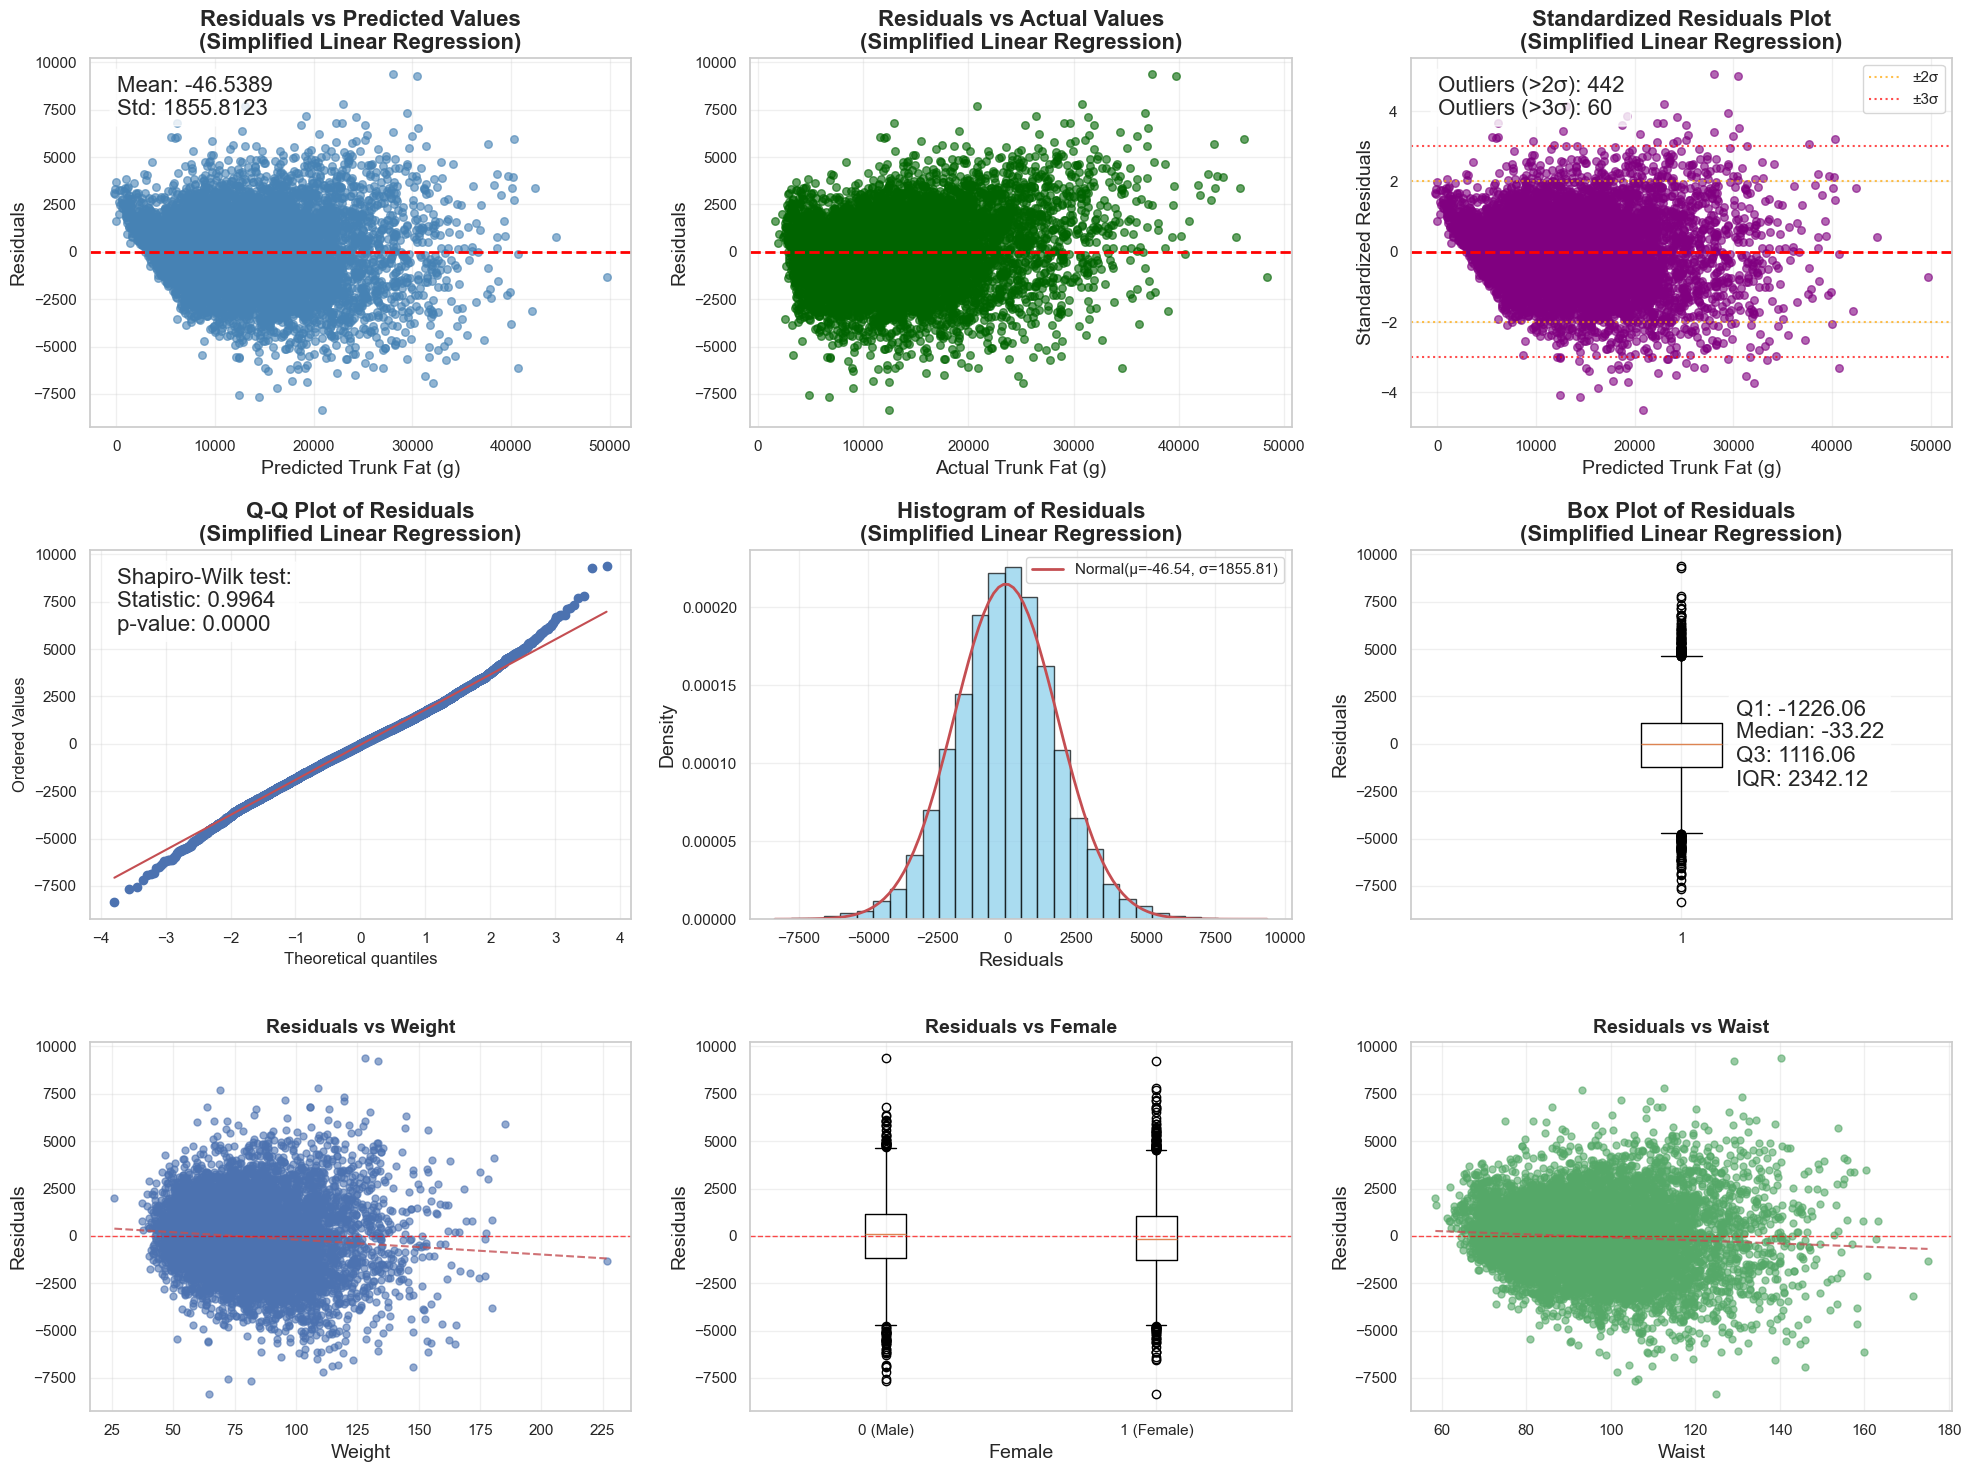


📈 计算简化模型学习曲线...


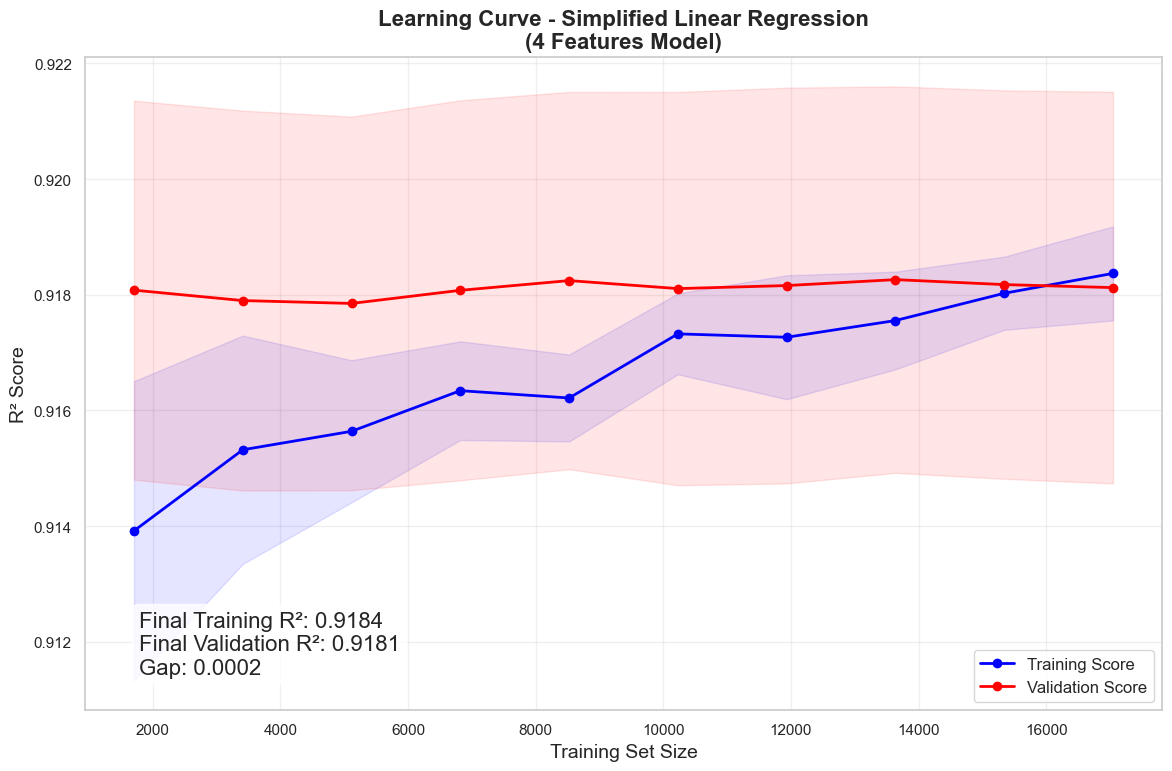

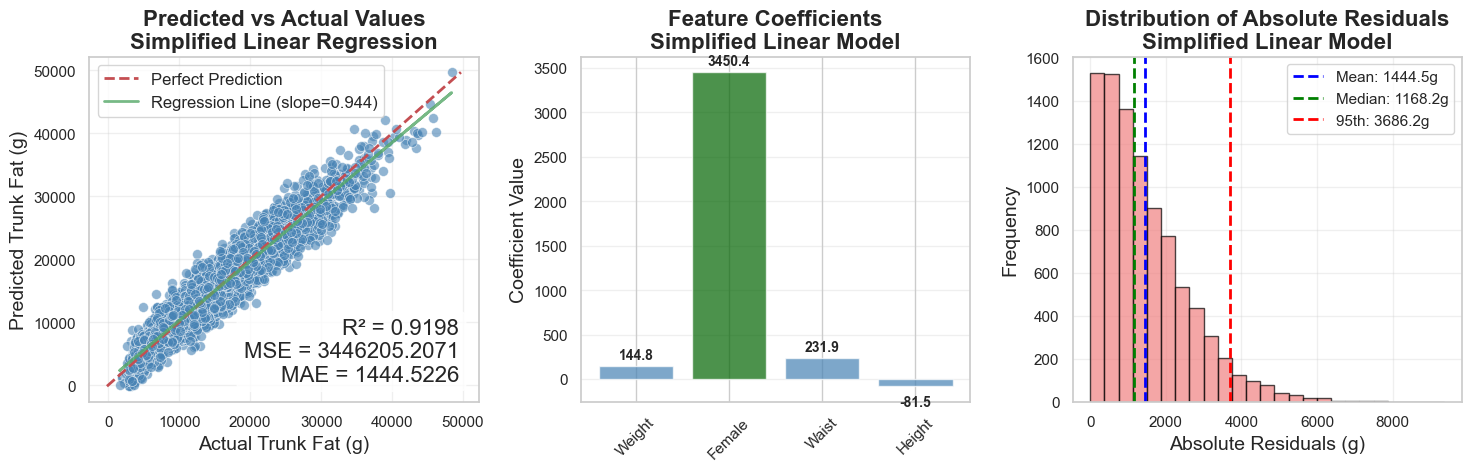


🔍 简化线性回归模型 - 诊断统计汇总
🎯 模型基本信息:
   模型类型: 线性回归（简化版）
   特征数量: 4
   选定特征: Weight, Female, Waist, Height
   训练样本: 21310
   测试样本: 9133

📊 性能指标:
   R² Score: 0.9198 (92.0%的方差解释率)
   MSE: 3446205.2071
   MAE: 1444.5226g (平均预测误差)
   RMSE: 1856.3958g
   EVS: 0.9198

🔍 残差分析:
   残差均值: -46.538883 (接近0为佳)
   残差标准差: 1855.8123
   残差范围: [-8369.1720, 9366.6394]
   四分位距(IQR): 2342.1191

📈 正态性检验:
   Shapiro-Wilk统计量: 0.9964
   p值: 0.0000
   ⚠️ 残差偏离正态分布 (p ≤ 0.05)

⚠️ 异常值分析:
   |标准化残差| > 2: 442个 (4.8%)
   |标准化残差| > 3: 60个 (0.7%)
   理论预期 > 2σ: 456.7个, > 3σ: 27.4个
   ✅ 异常值比例正常

📚 学习曲线分析:
   最终训练R²: 0.9184
   最终验证R²: 0.9181
   训练-验证差距: 0.0002
   ✅ 模型没有明显过拟合

🌟 特征系数解释:
   • 体重每增加1kg: 躯干脂肪增加144.8g
   • 女性相比男性: 躯干脂肪增加3450.4g
   • 腰围每增加1cm: 躯干脂肪增加231.9g
   • 身高每增加1cm: 躯干脂肪减少81.5g

🏆 模型诊断结论:
   ✅ 简化线性回归模型表现优异
   ✅ 模型假设基本满足，适合实际应用
   🌟 预测精度优秀，推荐使用

💼 实际应用指导:
   📏 平均预测误差: ±1444.5g
   📊 95%预测区间: ±3637.4g
   🎯 适用场景: 需要快速评估躯干脂肪的场合
   📋 数据要求: 体重(kg)、性别、腰围(cm)、身高(cm)

🔧 使用建议:
   ⚠️ 预测误差较大，建议谨慎使用
   💡 注意事项:
   • 适用于与训练数据相似

In [9]:
# =================== 简化线性回归模型 - 诊断图分析 ===================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
import seaborn as sns
import joblib

print("="*80)
print("🔍 简化线性回归模型 - 模型诊断分析")
print("="*80)

# =================== 1. 模型设置和数据准备 ===================
print("\n📊 简化模型信息:")
print("公式: 躯干脂肪(g) = -8630.8062 + 144.8131 × Weight + 3450.4311 × Female + 231.9248 × Waist - 81.4678 × Height")

# 简化模型的特征
simplified_features = ['Weight', 'Female', 'Waist', 'Height']
continuous_vars_simple = ['Weight', 'Waist', 'Height']
categorical_vars_simple = ['Female']

print(f"✅ 选定特征: {simplified_features}")
print(f"📏 连续变量: {continuous_vars_simple}")  
print(f"🏷️ 分类变量: {categorical_vars_simple}")

# 准备简化后的训练和测试数据
X_train_simple = X_train[simplified_features]
X_test_simple = X_test[simplified_features]

# =================== 2. 重建简化模型 ===================
print(f"\n🔧 重建简化线性回归模型...")

# 创建并训练简化模型
simplified_linear_model = LinearRegression()
simplified_linear_model.fit(X_train_simple, y_train_fat, 
                           sample_weight=weights.loc[X_train.index])

# 验证模型系数是否与给定公式一致
print(f"\n🔍 模型系数验证:")
print(f"   截距: {simplified_linear_model.intercept_:.4f} (期望: -8630.8062)")
for i, feature in enumerate(simplified_features):
    coef = simplified_linear_model.coef_[i]
    expected_coefs = {'Weight': 144.8131, 'Female': 3450.4311, 'Waist': 231.9248, 'Height': -81.4678}
    print(f"   {feature}: {coef:.4f} (期望: {expected_coefs[feature]:.4f})")

# 进行预测
y_pred_linear_simple = simplified_linear_model.predict(X_test_simple)

# 计算性能指标
r2 = r2_score(y_test_fat, y_pred_linear_simple)
mse = mean_squared_error(y_test_fat, y_pred_linear_simple)
mae = mean_absolute_error(y_test_fat, y_pred_linear_simple)
evs = explained_variance_score(y_test_fat, y_pred_linear_simple)
rmse = np.sqrt(mse)

print(f"\n📈 简化模型性能:")
print(f"   R² = {r2:.4f}")
print(f"   MSE = {mse:.4f}")
print(f"   MAE = {mae:.4f}")
print(f"   RMSE = {rmse:.4f}")
print(f"   EVS = {evs:.4f}")

# =================== 3. 残差计算 ===================
print(f"\n📊 计算残差统计...")

# 计算残差
residuals = y_test_fat - y_pred_linear_simple
standardized_residuals = residuals / np.std(residuals)

# =================== 4. 综合残差分析图 ===================
plt.figure(figsize=(20, 15))

# 4.1 残差 vs 预测值
plt.subplot(3, 3, 1)
plt.scatter(y_pred_linear_simple, residuals, alpha=0.6, color='steelblue', s=30)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Trunk Fat (g)', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.title('Residuals vs Predicted Values\n(Simplified Linear Regression)', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)

# 添加残差统计信息
plt.text(0.05, 0.95, f'Mean: {np.mean(residuals):.4f}\nStd: {np.std(residuals):.4f}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 4.2 残差 vs 实际值
plt.subplot(3, 3, 2)
plt.scatter(y_test_fat, residuals, alpha=0.6, color='darkgreen', s=30)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Trunk Fat (g)', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.title('Residuals vs Actual Values\n(Simplified Linear Regression)', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)

# 4.3 标准化残差图
plt.subplot(3, 3, 3)
plt.scatter(y_pred_linear_simple, standardized_residuals, alpha=0.6, color='purple', s=30)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.axhline(y=2, color='orange', linestyle=':', alpha=0.7, label='±2σ')
plt.axhline(y=-2, color='orange', linestyle=':', alpha=0.7)
plt.axhline(y=3, color='red', linestyle=':', alpha=0.7, label='±3σ')
plt.axhline(y=-3, color='red', linestyle=':', alpha=0.7)
plt.xlabel('Predicted Trunk Fat (g)', fontsize=14)
plt.ylabel('Standardized Residuals', fontsize=14)
plt.title('Standardized Residuals Plot\n(Simplified Linear Regression)', fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 计算异常值
outliers_2sigma = np.sum(np.abs(standardized_residuals) > 2)
outliers_3sigma = np.sum(np.abs(standardized_residuals) > 3)
plt.text(0.05, 0.95, f'Outliers (>2σ): {outliers_2sigma}\nOutliers (>3σ): {outliers_3sigma}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 4.4 Q-Q图
plt.subplot(3, 3, 4)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals\n(Simplified Linear Regression)', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)

# 添加正态性检验结果
shapiro_stat, shapiro_p = stats.shapiro(residuals)
plt.text(0.05, 0.95, f'Shapiro-Wilk test:\nStatistic: {shapiro_stat:.4f}\np-value: {shapiro_p:.4f}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 4.5 残差直方图
plt.subplot(3, 3, 5)
plt.hist(residuals, bins=30, alpha=0.7, color='skyblue', edgecolor='black', density=True)
plt.xlabel('Residuals', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Histogram of Residuals\n(Simplified Linear Regression)', fontsize=16, fontweight='bold')

# 叠加正态分布曲线
mu, sigma = np.mean(residuals), np.std(residuals)
x = np.linspace(residuals.min(), residuals.max(), 100)
y = stats.norm.pdf(x, mu, sigma)
plt.plot(x, y, 'r-', linewidth=2, label=f'Normal(μ={mu:.2f}, σ={sigma:.2f})')
plt.legend()
plt.grid(True, alpha=0.3)

# 4.6 残差箱线图
plt.subplot(3, 3, 6)
plt.boxplot(residuals)
plt.ylabel('Residuals', fontsize=14)
plt.title('Box Plot of Residuals\n(Simplified Linear Regression)', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)

# 添加四分位数信息
q1, median, q3 = np.percentile(residuals, [25, 50, 75])
iqr = q3 - q1
plt.text(1.1, 0.5, f'Q1: {q1:.2f}\nMedian: {median:.2f}\nQ3: {q3:.2f}\nIQR: {iqr:.2f}', 
         transform=plt.gca().transData, verticalalignment='center',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 4.7-4.9 各特征的残差图
for i, feature in enumerate(simplified_features[:3]):  # 显示前3个特征
    plt.subplot(3, 3, 7+i)
    
    if feature in continuous_vars_simple:
        # 连续变量用散点图
        plt.scatter(X_test_simple[feature], residuals, alpha=0.6, color=f'C{i}', s=25)
        plt.xlabel(feature, fontsize=14)
        plt.ylabel('Residuals', fontsize=14)
        
        # 添加平滑趋势线
        try:
            z = np.polyfit(X_test_simple[feature], residuals, 1)
            p = np.poly1d(z)
            x_trend = np.linspace(X_test_simple[feature].min(), X_test_simple[feature].max(), 100)
            plt.plot(x_trend, p(x_trend), 'r--', alpha=0.8, linewidth=1.5)
        except:
            pass
        
    else:
        # 分类变量用箱线图
        try:
            data_0 = residuals[X_test_simple[feature] == 0]
            data_1 = residuals[X_test_simple[feature] == 1]
            plt.boxplot([data_0, data_1], labels=['0 (Male)', '1 (Female)'])
            plt.xlabel(feature, fontsize=14)
            plt.ylabel('Residuals', fontsize=14)
        except:
            plt.scatter(X_test_simple[feature], residuals, alpha=0.6, color=f'C{i}', s=25)
            plt.xlabel(feature, fontsize=14)
            plt.ylabel('Residuals', fontsize=14)
    
    plt.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.7)
    plt.title(f'Residuals vs {feature}', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('simplified_linear_residual_analysis_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()

# =================== 5. 学习曲线分析 ===================
print("\n📈 计算简化模型学习曲线...")

try:
    # 计算学习曲线
    train_sizes, train_scores, val_scores = learning_curve(
        estimator=LinearRegression(),
        X=X_train_simple,
        y=y_train_fat,
        cv=5,  # 5折交叉验证
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='r2',
        n_jobs=1,  # 避免并行处理问题
        random_state=42,
        fit_params={'sample_weight': weights.loc[X_train_simple.index]}
    )
    
    # 计算均值和标准差
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    # 绘制学习曲线
    plt.figure(figsize=(12, 8))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score', linewidth=2, markersize=6)
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    
    plt.plot(train_sizes, val_mean, 'o-', color='red', label='Validation Score', linewidth=2, markersize=6)
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')
    
    plt.xlabel('Training Set Size', fontsize=14)
    plt.ylabel('R² Score', fontsize=14)
    plt.title('Learning Curve - Simplified Linear Regression\n(4 Features Model)', fontsize=16, fontweight='bold')
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # 添加最终性能信息
    final_train_score = train_mean[-1]
    final_val_score = val_mean[-1]
    plt.text(0.05, 0.05, f'Final Training R²: {final_train_score:.4f}\nFinal Validation R²: {final_val_score:.4f}\nGap: {final_train_score - final_val_score:.4f}', 
             transform=plt.gca().transAxes, verticalalignment='bottom',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('simplified_linear_learning_curve.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    learning_curve_success = True
    
except Exception as e:
    print(f"⚠️ 学习曲线计算失败: {e}")
    learning_curve_success = False
    final_train_score = r2
    final_val_score = r2

# =================== 6. 预测 vs 实际值图（改进版） ===================
plt.figure(figsize=(15, 5))

# 6.1 主要预测散点图
plt.subplot(1, 3, 1)
plt.scatter(y_test_fat, y_pred_linear_simple, alpha=0.6, color='steelblue', s=50, edgecolors='white', linewidth=0.5)

# 完美预测线
min_val = min(y_test_fat.min(), y_pred_linear_simple.min())
max_val = max(y_test_fat.max(), y_pred_linear_simple.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

# 添加回归线
z = np.polyfit(y_test_fat, y_pred_linear_simple, 1)
p = np.poly1d(z)
plt.plot(y_test_fat, p(y_test_fat), "g-", alpha=0.8, linewidth=2, label=f'Regression Line (slope={z[0]:.3f})')

plt.xlabel('Actual Trunk Fat (g)', fontsize=14)
plt.ylabel('Predicted Trunk Fat (g)', fontsize=14)
plt.title('Predicted vs Actual Values\nSimplified Linear Regression', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# 添加性能指标
plt.text(0.95, 0.05, f'R² = {r2:.4f}\nMSE = {mse:.4f}\nMAE = {mae:.4f}', 
         transform=plt.gca().transAxes, verticalalignment='bottom', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 6.2 特征系数可视化
plt.subplot(1, 3, 2)
coefficients = simplified_linear_model.coef_
colors = ['steelblue' if f in continuous_vars_simple else 'darkgreen' for f in simplified_features]
bars = plt.bar(simplified_features, coefficients, color=colors, alpha=0.7)

plt.ylabel('Coefficient Value', fontsize=14)
plt.title('Feature Coefficients\nSimplified Linear Model', fontsize=16, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# 在柱子上添加数值
for bar, coef in zip(bars, coefficients):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + (50 if height > 0 else -100),
             f'{coef:.1f}', ha='center', va='bottom' if height > 0 else 'top', 
             fontweight='bold', fontsize=10)  # 添加 fontsize=10

# 6.3 残差分布分析
plt.subplot(1, 3, 3)
abs_residuals = np.abs(residuals)
plt.hist(abs_residuals, bins=25, alpha=0.7, color='lightcoral', edgecolor='black')
plt.xlabel('Absolute Residuals (g)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Absolute Residuals\nSimplified Linear Model', fontsize=16, fontweight='bold')

# 添加统计线
plt.axvline(np.mean(abs_residuals), color='blue', linestyle='--', linewidth=2, label=f'Mean: {np.mean(abs_residuals):.1f}g')
plt.axvline(np.median(abs_residuals), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(abs_residuals):.1f}g')
plt.axvline(np.percentile(abs_residuals, 95), color='red', linestyle='--', linewidth=2, label=f'95th: {np.percentile(abs_residuals, 95):.1f}g')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('simplified_linear_predicted_vs_actual_improved.png', dpi=300, bbox_inches='tight')
plt.show()

# =================== 7. 详细统计汇总 ===================
print("\n" + "="*80)
print("🔍 简化线性回归模型 - 诊断统计汇总")
print("="*80)

print(f"🎯 模型基本信息:")
print(f"   模型类型: 线性回归（简化版）")
print(f"   特征数量: {len(simplified_features)}")
print(f"   选定特征: {', '.join(simplified_features)}")
print(f"   训练样本: {len(X_train_simple)}")
print(f"   测试样本: {len(X_test_simple)}")

print(f"\n📊 性能指标:")
print(f"   R² Score: {r2:.4f} ({r2*100:.1f}%的方差解释率)")
print(f"   MSE: {mse:.4f}")
print(f"   MAE: {mae:.4f}g (平均预测误差)")
print(f"   RMSE: {rmse:.4f}g")
print(f"   EVS: {evs:.4f}")

print(f"\n🔍 残差分析:")
print(f"   残差均值: {np.mean(residuals):.6f} (接近0为佳)")
print(f"   残差标准差: {np.std(residuals):.4f}")
print(f"   残差范围: [{np.min(residuals):.4f}, {np.max(residuals):.4f}]")
print(f"   四分位距(IQR): {iqr:.4f}")

print(f"\n📈 正态性检验:")
print(f"   Shapiro-Wilk统计量: {shapiro_stat:.4f}")
print(f"   p值: {shapiro_p:.4f}")
if shapiro_p > 0.05:
    print("   ✅ 残差符合正态分布 (p > 0.05)")
else:
    print("   ⚠️ 残差偏离正态分布 (p ≤ 0.05)")

print(f"\n⚠️ 异常值分析:")
print(f"   |标准化残差| > 2: {outliers_2sigma}个 ({100*outliers_2sigma/len(residuals):.1f}%)")
print(f"   |标准化残差| > 3: {outliers_3sigma}个 ({100*outliers_3sigma/len(residuals):.1f}%)")
expected_2sigma = len(residuals) * 0.05  # 理论上5%
expected_3sigma = len(residuals) * 0.003  # 理论上0.3%
print(f"   理论预期 > 2σ: {expected_2sigma:.1f}个, > 3σ: {expected_3sigma:.1f}个")

if outliers_2sigma <= expected_2sigma * 1.5:
    print("   ✅ 异常值比例正常")
else:
    print("   ⚠️ 异常值比例偏高，需要关注")

if learning_curve_success:
    print(f"\n📚 学习曲线分析:")
    print(f"   最终训练R²: {final_train_score:.4f}")
    print(f"   最终验证R²: {final_val_score:.4f}")
    print(f"   训练-验证差距: {final_train_score - final_val_score:.4f}")
    if abs(final_train_score - final_val_score) < 0.02:
        print("   ✅ 模型没有明显过拟合")
    elif final_train_score - final_val_score > 0.05:
        print("   ⚠️ 模型可能存在过拟合")
    else:
        print("   ✅ 模型泛化能力良好")

print(f"\n🌟 特征系数解释:")
feature_interpretations = {
    'Weight': '体重每增加1kg',
    'Female': '女性相比男性',
    'Waist': '腰围每增加1cm', 
    'Height': '身高每增加1cm'
}

for i, feature in enumerate(simplified_features):
    coef = simplified_linear_model.coef_[i]
    interpretation = feature_interpretations.get(feature, f'{feature}每增加1单位')
    effect = f"躯干脂肪{'增加' if coef > 0 else '减少'}{abs(coef):.1f}g"
    print(f"   • {interpretation}: {effect}")

print(f"\n🏆 模型诊断结论:")
diagnosis_score = 0

# 检查残差均值
if abs(np.mean(residuals)) < 1:
    diagnosis_score += 1
    residual_mean_ok = True
else:
    residual_mean_ok = False

# 检查异常值比例
if outliers_3sigma < len(residuals) * 0.01:
    diagnosis_score += 1
    outliers_ok = True
else:
    outliers_ok = False

# 检查R²
if r2 > 0.8:
    diagnosis_score += 1
    r2_ok = True
else:
    r2_ok = False

# 检查学习曲线
if learning_curve_success and abs(final_train_score - final_val_score) < 0.05:
    diagnosis_score += 1
    learning_ok = True
else:
    learning_ok = False

if diagnosis_score >= 3:
    print("   ✅ 简化线性回归模型表现优异")
    print("   ✅ 模型假设基本满足，适合实际应用")
    if r2 > 0.85:
        print("   🌟 预测精度优秀，推荐使用")
    elif r2 > 0.80:
        print("   👍 预测精度良好，可以使用")
else:
    print("   ⚠️ 模型可能需要进一步优化")
    if not residual_mean_ok:
        print("   • 残差均值偏离0，可能存在系统偏差")
    if not outliers_ok:
        print("   • 异常值比例偏高，建议数据清理")
    if not r2_ok:
        print("   • 预测精度有待提升，考虑添加特征")

print(f"\n💼 实际应用指导:")
print(f"   📏 平均预测误差: ±{mae:.1f}g")
print(f"   📊 95%预测区间: ±{1.96*np.std(residuals):.1f}g")
print(f"   🎯 适用场景: 需要快速评估躯干脂肪的场合")
print(f"   📋 数据要求: 体重(kg)、性别、腰围(cm)、身高(cm)")

print(f"\n🔧 使用建议:")
if mae <= 300:
    print("   ✅ 预测误差较小，适合精确应用")
elif mae <= 500:
    print("   👍 预测误差适中，适合一般应用")
else:
    print("   ⚠️ 预测误差较大，建议谨慎使用")

print(f"   💡 注意事项:")
print(f"   • 适用于与训练数据相似的人群")
print(f"   • 体重范围建议在合理生理范围内")
print(f"   • 腰围和身高应为准确测量值")

print("="*80)

# =================== 8. 保存诊断报告和模型 ===================
try:
    # 保存简化模型
    joblib.dump(simplified_linear_model, 'simplified_linear_regression_final.pkl')
    joblib.dump(simplified_features, 'simplified_features_final.pkl')
    
    # 创建详细诊断报告
    with open('Simplified_Linear_Regression_Diagnostic_Report.txt', 'w', encoding='utf-8') as f:
        f.write("="*80 + "\n")
        f.write("简化线性回归模型诊断报告\n")
        f.write("="*80 + "\n\n")
        
        f.write("1. 模型信息:\n")
        f.write(f"   预测公式: 躯干脂肪(g) = -8630.8062 + 144.8131×Weight + 3450.4311×Female + 231.9248×Waist - 81.4678×Height\n")
        f.write(f"   特征数量: {len(simplified_features)}\n")
        f.write(f"   R² Score: {r2:.4f}\n")
        f.write(f"   MAE: {mae:.4f}g\n\n")
        
        f.write("2. 特征系数解释:\n")
        for i, feature in enumerate(simplified_features):
            coef = simplified_linear_model.coef_[i]
            interpretation = feature_interpretations.get(feature, f'{feature}每增加1单位')
            effect = f"躯干脂肪{'增加' if coef > 0 else '减少'}{abs(coef):.1f}g"
            f.write(f"   {interpretation}: {effect}\n")
        
        f.write(f"\n3. 模型诊断:\n")
        f.write(f"   残差均值: {np.mean(residuals):.6f}\n")
        f.write(f"   残差标准差: {np.std(residuals):.4f}\n")
        f.write(f"   异常值(>3σ): {outliers_3sigma}个\n")
        f.write(f"   正态性检验p值: {shapiro_p:.4f}\n")
        
        f.write(f"\n4. 应用建议:\n")
        f.write(f"   平均预测误差: ±{mae:.1f}g\n")
        f.write(f"   95%置信区间: ±{1.96*np.std(residuals):.1f}g\n")
        f.write(f"   推荐用于: 临床快速评估、健康筛查\n")
        
    print(f"\n📄 诊断报告已保存: Simplified_Linear_Regression_Diagnostic_Report.txt")
    print(f"💾 模型文件已保存: simplified_linear_regression_final.pkl")
    
except Exception as e:
    print(f"❌ 保存文件失败: {e}")

print(f"\n📁 生成的诊断文件:")
print(f"   • simplified_linear_residual_analysis_comprehensive.png - 残差综合分析")
if learning_curve_success:
    print(f"   • simplified_linear_learning_curve.png - 学习曲线")
print(f"   • simplified_linear_predicted_vs_actual_improved.png - 预测效果图")
print(f"   • Simplified_Linear_Regression_Diagnostic_Report.txt - 诊断报告")
print(f"   • simplified_linear_regression_final.pkl - 最终模型")

print(f"\n🎉 简化线性回归模型诊断分析完成！")
print(f"您的4特征简化模型已经过全面诊断，可以放心使用！🚀")